## Load Libraries and Data

In [1]:
import rputils.rputils as rp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from IPython.display import HTML, display
import pandas as pd
from scipy import integrate, optimize

from sympy import symbols, Eq, solve

import matplotlib.ticker as mticker
# from matplotlib.ticker import FuncFormatter
def sci_format_short(x,lim):
    return '{:.0e}'.format(x)
major_formatter = mticker.FuncFormatter(sci_format_short)

## Define consistent color to use for the 4 pressure steps
pres_colors = ["dimgray", "brown", "royalblue", "darkgoldenrod"]

In [2]:
"""
Load all data
"""
## Particle size distribution
data_path = "../../../Research Work/Lab Measurements/Grain Size/LHT-1g_ParticleSize.txt"
particle_data = np.genfromtxt(data_path, skip_header=1)


## Velocity data
## Data loads as [sample number, (vp, bulk density, porosity)]
data_path = "../data/velocity_picks/0_ice_vp.txt"
data_p = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/velocity_picks/0_ice_vs.txt"
data_s = np.genfromtxt(data_path, skip_header=1)


## Pressure-velocity data
## Data loads as [sample number, (vp, bulk density, porosity, pressure (MPa))]
data_path = "../data/velocity_picks/0_ice_vp_pressure.txt"
data_pressure_p = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/velocity_picks/0_ice_vs_pressure.txt"
data_pressure_s = np.genfromtxt(data_path, skip_header=1)

pressures = [0.000005, 0.00003, 0.000055, 0.00008] # in GPa
pres_step_0_p = data_pressure_p[np.where(data_pressure_p[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_p = data_pressure_p[np.where(data_pressure_p[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_p = data_pressure_p[np.where(data_pressure_p[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_p = data_pressure_p[np.where(data_pressure_p[:,-1]==round(pressures[3]*1000,3))]

pres_step_0_s = data_pressure_s[np.where(data_pressure_s[:,-1]==round(pressures[0]*1000,3))]
pres_step_1_s = data_pressure_s[np.where(data_pressure_s[:,-1]==round(pressures[1]*1000,3))]
pres_step_2_s = data_pressure_s[np.where(data_pressure_s[:,-1]==round(pressures[2]*1000,3))]
pres_step_3_s = data_pressure_s[np.where(data_pressure_s[:,-1]==round(pressures[3]*1000,3))]


## Combined data
## Data loads as [sample number, (vp, vs, bulk density, porosity)]
data_path = "../data/velocity_picks/0_ice_combined.txt"
data_comb = np.genfromtxt(data_path, skip_header=1)


## Vacuum data
## Data loads as [sample number, (vp, bulk density, porosity, vacuum classifier)]
## Vacuum classifier: 0=pre vac, 1=vacuum, 2=post-vac
data_path = "../data/velocity_picks/0_ice_vp_vacuum.txt"
data_p_vacuum = np.genfromtxt(data_path, skip_header=1)
data_path = "../data/velocity_picks/0_ice_vs_vacuum.txt"
data_s_vacuum = np.genfromtxt(data_path, skip_header=1)


## Lab velocities from Johnson
johnson_path = "../data/Johnson_Apollo_Lab.txt"
johnson_data = np.genfromtxt(johnson_path, dtype=np.float32, skip_header=6, encoding='utf-8')
johnson_data[:,2] = johnson_data[:,2] /10  #convert Bar to MPa

## Calculate an Effective Mineral

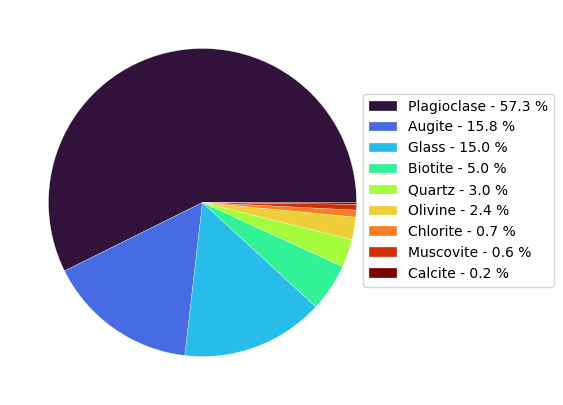

Constituent,Volume Fraction,Bulk Modulus (GPa),Shear Modulus (GPa),Density (g/cm3),P-Velocity (m/s),S-Velocity (m/s),Source
Plagioclase,0.573,84.2,39.9,2.73,7094,3823,"Hearmon, 1984"
Augite,0.158,95.0,59.0,3.26,7298,4254,"Bass, 2013"
Glass,0.15,69.2,38.7,2.69,6701,3792,"Wang, 1989"
Biotite,0.05,59.7,42.3,3.05,6169,3724,"Mavko et al., 2020"
Quartz,0.03,37.9,44.3,2.65,6049,4088,"McSkimin et al., 1965"
Olivine,0.024,130.0,80.0,3.32,8443,4908,"Carmichael, 1989"
Chlorite,0.007,164.3,81.9,2.84,9813,5370,"Wang et al., 2001"
Muscovite,0.006,58.2,41.1,2.79,6364,3838,"Vaughan & Guggenheim, 1986"
Calcite,0.002,76.8,32.0,2.71,6639,3436,"Simmons & Wang, 1971"
Effective Mineral,1,80.9,43.5,2.98,6827,3819,


In [3]:
"""
Calculate effective mineral properties based on major 
mineral constituents of LHT-1g

Top 9 minerals were used from lab volume analysis,
representing 96.7% of total volume

k: bulk modulus, u: shear modulus
f: volume fraction, d: density
"""

## Keep this same order in the lists below
minerals = ["Plagioclase", "Augite", "Glass", "Biotite", "Quartz",
           "Olivine", "Chlorite", "Muscovite", "Calcite"]

## Input published elastic values
## Sources mix of Bass, Wang, and RP Handbook

## Mineral values:
k_plag, u_plag, f_plag, d_plag = 84.2, 39.9, 0.5733, 2.73     
k_augite, u_augite, f_augite, d_augite = 95, 59, 0.1584, 3.26 
k_glass, u_glass, f_glass, d_glass = 69.2, 38.7, 0.1499, 2.69 # CaAl2Si2O8 glass
k_biotite, u_biotite, f_biotite, d_biotite = 59.7, 42.3, 0.0501, 3.05 
k_quartz, u_quartz, f_quartz, d_quartz = 37.9, 44.3, 0.0296, 2.65
k_olivine, u_olivine, f_olivine, d_olivine = 130, 80, 0.0235, 3.32  
k_chlorite, u_chlorite, f_chlorite, d_chlorite = 164.3, 81.9, 0.0073, 2.84 
k_muscovite, u_muscovite, f_muscovite, d_muscovite = 58.2, 41.1, 0.0061, 2.79 
k_calcite, u_calcite, f_calcite, d_calcite = 76.8, 32., 0.0018, 2.71 

## Gather mineral values into lists, use mineral order from above
min_volume_fractions = [f_plag, f_augite, f_glass, f_biotite, f_quartz,
                       f_olivine, f_chlorite, f_muscovite, f_calcite]
min_bulk_mods = [k_plag, k_augite, k_glass, k_biotite, k_quartz,
                       k_olivine, k_chlorite, k_muscovite, k_calcite]
min_shear_mods = [u_plag, u_augite, u_glass, u_biotite, u_quartz,
                       u_olivine, u_chlorite, u_muscovite, u_calcite]
min_densities = [d_plag, d_augite, d_glass, d_biotite, d_quartz,
                       d_olivine, d_chlorite, d_muscovite, d_calcite]
min_pvels = [rp.p_vel_mod(k,u,d) for k,u,d in zip(min_bulk_mods, min_shear_mods, min_densities)]
min_svels = [rp.s_vel_mod(u,d) for u,d in zip(min_shear_mods, min_densities)]
min_vpvs = [p/s for p, s in zip(min_pvels, min_svels)]


## Calculate effective properties
## Note: difference between Hill Average and LS lower is minimal in this case
## Hill Average and HS average produce identical results
_kL, _uL = rp.hs_bound('lower', min_volume_fractions, 
                                                    min_bulk_mods, min_shear_mods, porosity=0)
_kU, _uU = rp.hs_bound('upper', min_volume_fractions, 
                                                    min_bulk_mods, min_shear_mods, porosity=0)
effective_mineral_k, effective_mineral_u = np.mean((_kL, _kU)), np.mean((_uL, _uU))
# eff_min_density = sum([f*d for f, d in zip(min_volume_fractions, min_densities)])
eff_min_density = 2.98  ## override calculation w/ measured value
eff_min_vp = rp.p_vel_mod(effective_mineral_k, effective_mineral_u, eff_min_density)
eff_min_vs = rp.s_vel_mod(effective_mineral_u, eff_min_density)
eff_min_vpvs = eff_min_vp/eff_min_vs
poisson_grain = rp.poisson_mod(effective_mineral_k, effective_mineral_u)

## Pie chart of mineral constituents
n_colors = len(minerals)
plot_colors = plt.cm.turbo(np.linspace(0.,1.,n_colors))

plt.figure(figsize=(5,5))
pie, _ = plt.pie(min_volume_fractions, colors=plot_colors,
                wedgeprops={"edgecolor":"white", "linewidth":0.2})
pie_labels = [f'{i} - {j*100:.1f} %' for i,j in zip(minerals, min_volume_fractions)]
plt.legend(pie, pie_labels, bbox_to_anchor=(0.9, 0.8),fontsize=10)
plt.show()


## Table of constituent properties
sources = ["Hearmon, 1984", "Bass, 2013", "Wang, 1989", "Mavko et al., 2020", "McSkimin et al., 1965",
          "Carmichael, 1989", "Wang et al., 2001", "Vaughan & Guggenheim, 1986", "Simmons & Wang, 1971"]
table_data=[]
for _ in range(len(minerals)):
    tmp_list = []
    tmp_list.append(minerals[_])
    tmp_list.append(round(min_volume_fractions[_],3))
    tmp_list.append(round(min_bulk_mods[_],1))
    tmp_list.append(round(min_shear_mods[_],1))
    tmp_list.append(round(min_densities[_],2))
    tmp_list.append(int(min_pvels[_]*1000))
    tmp_list.append(int(min_svels[_]*1000))
    # tmp_list.append(round(min_vpvs[_],2))
    tmp_list.append(sources[_])
    table_data.append(tmp_list)
eff_print_list = []
eff_print_list.append("Effective Mineral")
eff_print_list.append("1")
eff_print_list.append(round(effective_mineral_k,1))
eff_print_list.append(round(effective_mineral_u,1))
eff_print_list.append(round(eff_min_density,2))
eff_print_list.append(int(eff_min_vp*1000))
eff_print_list.append(int(eff_min_vs*1000))
# eff_print_list.append(round(eff_min_vpvs,2))
table_data.append(eff_print_list)
    
table_df = pd.DataFrame(table_data, columns=['Constituent', 'Volume Fraction','Bulk Modulus (GPa)',
                                            'Shear Modulus (GPa)', 'Density (g/cm3)',
                                            'P-Velocity (m/s)', 'S-Velocity (m/s)',
                                            'Source'])
table_df.fillna("",inplace=True)
table_df = table_df.to_html(index=False)

HTML(table_df)


## Particle Size Distribution

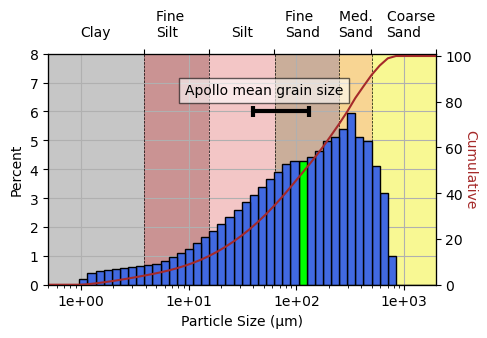

In [4]:
"""
Plot particle size distribution from LHT-1G, compare to Apollo
"""

particle_sizes = particle_data[:,0]
particle_percents = particle_data[:,1]
particle_cumulative = particle_data[:,2]
particle_mean_bin = (np.abs(particle_cumulative - 50)).argmin()
particle_mean = particle_sizes[particle_mean_bin]

## From Wentworth scale, in microns
particle_boundaries=[3.9, 15.6, 63, 250, 500, 2000]

fig, ax = plt.subplots(figsize=(5,3))
xlims=(2**-1, 12.5**3)
zorder = 5

## Cumulative plot
twinx = ax.twinx()
cumu_plot = twinx.plot(particle_sizes, particle_cumulative, color="brown", zorder=zorder+3)
twinx.yaxis.label.set_color(cumu_plot[0].get_color())
twinx.set_ylabel("Cumulative", rotation=270)
twinx.set(ylim=(0, 101),
          xlim=(xlims[0], xlims[1]),
          xscale=("log"))

## Grain size plot
sizeax = ax.twiny()
sizeax.set(xlim=(xlims[0], xlims[1]),
          xscale="log")
sizeax.set_xticks(ticks=particle_boundaries) #NOTE: this MUST be called AFTER setting log scale
sizeax.get_xaxis().set_tick_params(which='minor', size=0, width=0)
sizeax.text(1, 8.5, "Clay", va="bottom", ha="left", rotation=0)
sizeax.text(5, 8.5, "Fine \nSilt", va="bottom", ha="left", rotation=0)
sizeax.text(25, 8.5, "Silt", va="bottom", ha="left", rotation=0)
sizeax.text(80, 8.5, "Fine \nSand", va="bottom", ha="left", rotation=0)
sizeax.text(250, 8.5, "Med. \nSand", va="bottom", ha="left", rotation=0)
sizeax.text(700, 8.5, "Coarse \nSand", va="bottom", ha="left", rotation=0)

## Percents bar plot
bin_widths = np.pad(np.diff(particle_sizes), (0,1), mode="edge")
bar_plot = ax.bar(particle_sizes, particle_percents, width=bin_widths, align="edge",
      color="royalblue", edgecolor="black", zorder=zorder+3)
bar_plot[particle_mean_bin].set_color("lime")
bar_plot[particle_mean_bin].set_edgecolor("black")
ax.set(xscale="log",
       ylim=(0, 8),
       xlim=(xlims[0], xlims[1]),
      axisbelow=True,
      facecolor="whitesmoke",
      ylabel="Percent",
       xlabel="Particle Size (\u03BCm)") 
      # xlabel="Particle Size ({}m)".format(r'$\mu$'))  
    #("Average {} (measured)".format(r'$\nu$')))    \u03BC
ax.grid(which="major")
grain_colors = ["gray", "darkred", "lightcoral", "saddlebrown", "orange", "yellow"]
for i, b in enumerate(particle_boundaries):
    if i==0:
        start = 0
    else:
        start = particle_boundaries[i-1]
    end = b
    ## Have to plot on `ax` to get behind bar chart
    ax.axvspan(start, end, color=grain_colors[i], alpha=0.4, zorder=-1, lw=0)
    if i != len(particle_boundaries)-1:
        ax.axvline(end, color="black", ls="--", lw=0.5)
ax.xaxis.set_major_formatter(major_formatter)

## Apollo bar for comparison
ax.hlines(y=6, xmin=40, xmax=130, color="black", lw=3)
ax.vlines(x=40, ymin=5.8, ymax=6.2, color="black", lw=3)
ax.vlines(x=130, ymin=5.8, ymax=6.2, color="black", lw=3)
ax.text(50, 6.6, "Apollo mean grain size", 
        bbox={"facecolor":"white", "alpha":0.6, "edgecolor":"black"},
       horizontalalignment='center')

plt.show()


## Rock Physics Modeling

In [4]:
## Establish a few parameters here to keep organized

critical_porosity = 0.66  # 0.664 average from helium pyc, even higher on low-accuracy liquid pyc
fitting_por = 0.42  # fit porosity for max_poissons
# max_poisson_list = [0.44, 0.426, 0.409, 0.404]
max_poisson_list = [0.44, 0.426, 0.415, 0.409]  # Based on the observed average velocities
contact_ratios = [0.5, 0.8, 0.8, 0.8]  # for Bachrach HM
slip_percent = 0.5  # for Bachrach HM

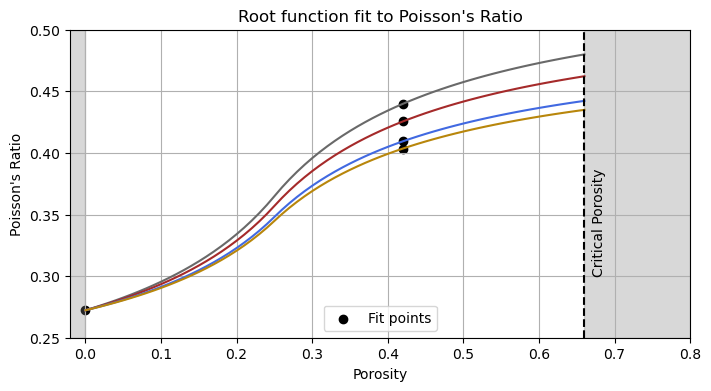

In [15]:
"""
It is observed that even including slip factor and grain
contact ratio (after Bachrach) the shear velocity is still
overpredicted. To compensate, this workflow uses the average
Vp and Vs at each pressure step to calculate a fitting Poisson's
ratio. A function is fit between these points and the mineral
Poisson's ratio versus porosity. The effective shear modulus
will then be estimated based on the calculated effective bulk
modulus and this PR fitting function for each pressure step.

Use a root function to fit between mineral PR and averaged
fitting PR under the notion that near critical porosity or the 
mineral point, PR will behave similar to those end member conditions.

This cell illustrates how the "fitting_por" and "max_poisson_list"
variables are determined
"""

## Average porosity for the Vp and Vs pressure measurements
fit_avg_por = np.mean((np.mean(data_pressure_p[:,2]), np.mean(data_pressure_s[:,2])))
fit_avg_por = 0.42  ## manual overwrite
# print(f"The average fitting porosity is {round(fit_avg_por,2)}")

## Average Poisson's Ratio at each pressure step
p0_avg_pr = rp.poisson_vel(np.mean(pres_step_0_p[:,0]), np.mean(pres_step_0_s[:,0]))
p1_avg_pr = rp.poisson_vel(np.mean(pres_step_1_p[:,0]), np.mean(pres_step_1_s[:,0]))
p2_avg_pr = rp.poisson_vel(np.mean(pres_step_2_p[:,0]), np.mean(pres_step_2_s[:,0]))
p3_avg_pr = rp.poisson_vel(np.mean(pres_step_3_p[:,0]), np.mean(pres_step_3_s[:,0]))
fit_poissons = [p0_avg_pr, p1_avg_pr, p2_avg_pr, p3_avg_pr]
# print(f"The fitting Poisson's Ratios are: {[round(i,3) for i in fit_poissons]}")


## Define the root function that will be used for fitting,
## holding two variables constant to control the degree
## and location of function slope
def fit_func_bounded(x, vert_stretch, vert_translate):
    horz_translate = 0.25
    curve_factor = 0.25
    return vert_stretch * ((x-horz_translate)/(curve_factor + np.abs(x-horz_translate))) + vert_translate


## For each pressure step, fit the PR-fitting function
x = np.arange(0, critical_porosity+0.01, 0.01)
fit_parms = []
initial_guess = [0.2, 0.3]
for pr in fit_poissons:
    fit_x = [0, fit_avg_por]
    fit_y = [poisson_grain, pr]
    fit_parm, _ = optimize.curve_fit(fit_func_bounded, fit_x, fit_y, p0=initial_guess)
    fit_parms.append(fit_parm)

## PR points for plotting
pr_x = [0, fit_avg_por, fit_avg_por, fit_avg_por, fit_avg_por]
pr_y = [poisson_grain, fit_poissons[0], fit_poissons[1], fit_poissons[2], fit_poissons[3]]

## QC plot
plt.figure(figsize=(8,4))
plt.scatter(pr_x, pr_y, c="black", label="Fit points")
for i, fit_parm in enumerate(fit_parms):
    plt.plot(x, fit_func_bounded(x, *fit_parm), color=pres_colors[i])
plt.gca().axvspan(-1, 0, color="gray", alpha=0.3)
plt.gca().axvspan(critical_porosity, 1, color="gray", alpha=0.3)
plt.axvline(critical_porosity, linestyle="--", color="black")
plt.gca().text(critical_porosity+0.01,0.3, "Critical Porosity", va="bottom", ha="left", rotation=90)
plt.grid("both")
plt.xlabel("Porosity")
plt.ylabel("Poisson's Ratio")
plt.title("Root function fit to Poisson's Ratio")
plt.legend()
plt.xlim(-0.02, 0.8)
plt.ylim(0.25, 0.5)
plt.show()

C:\Users\amos\miniconda3\envs\cadiss\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


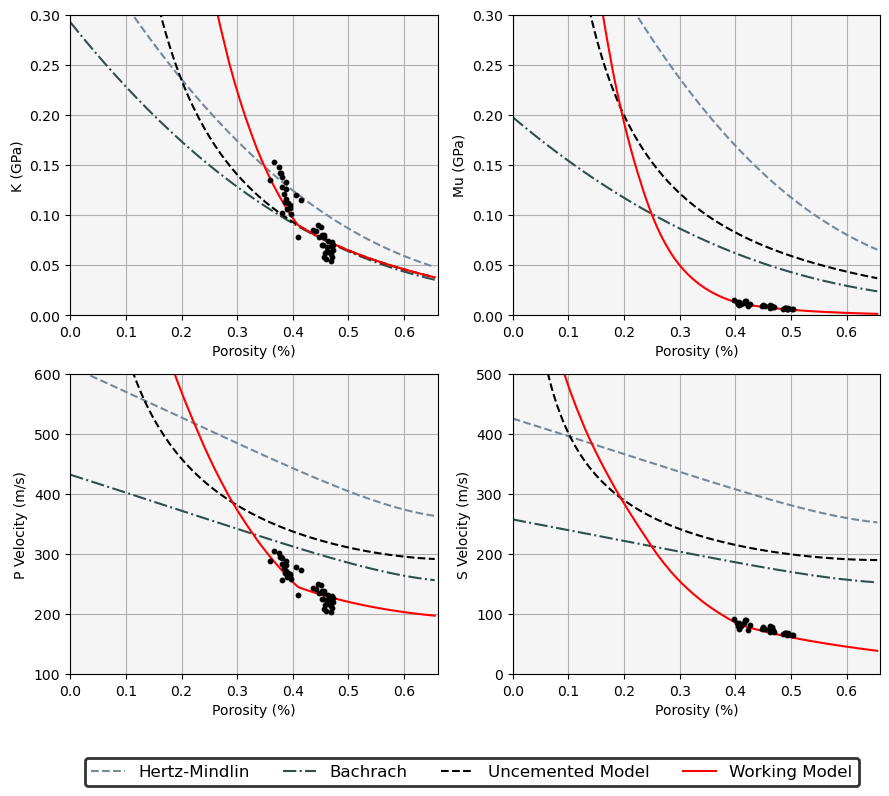

In [18]:
"""
Load the Vp / porosity data picks, plot with
model fit based on effective minerals

Investigate impact of mineral moduli variations in literature
on model fits, investigate various models
"""


## Model Parameters
pressure = pressures[0]  #GPa for calculations
max_poisson = max_poisson_list[0]

## Calculate RP models
por_range = np.arange(0,critical_porosity, 0.005)

vp_amos, vs_amos, k_amos, mu_amos = [], [], [], []
vp_bach, vs_bach, k_bach, mu_bach = [], [], [], []
vp_hm, vs_hm, k_hm, mu_hm = [], [], [], []
vp_uncem, vs_uncem, k_uncem, mu_uncem = [], [], [], []


for por in por_range:
    C_murphy = rp.modified_murphy(por)
    # C_murphy = rp.upper_murphy(por)
    C = 3
    dens = eff_min_density*(1-por)

    ## NOTE: pay attention if you need to use current or critical porosity!
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     pressure, c_ratio = contact_ratios[0], slip_percent = slip_percent)
    kbach, ubach = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, por, C_murphy,
                                     pressure, c_ratio = .4, slip_percent = 0.9)
    khm, uhm = rp.hertz_mindlin(effective_mineral_k, effective_mineral_u, por, C_murphy,
                                     pressure, f=1)
    # kdigby, udigby = rp.digby(effective_mineral_k, effective_mineral_u, por, C_murphy, 
    #                       pressure, bond_ratio=0.01)
    # kwalton, uwalton = rp.walton(effective_mineral_k, effective_mineral_u, por, C_murphy, 
    #                        pressure, mode="smooth")
    
    keff_uncem, ueff_uncem = rp.uncemented_model(por, critical_porosity, keff, ueff, 
                                              effective_mineral_k, effective_mineral_u)
    keff_amos, ueff_amos = rp.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=max_poisson,
                                           trans_por=0.41)

    vp_amos.append(rp.p_vel_mod(keff_amos, ueff_amos, dens)*1000)
    vs_amos.append(rp.s_vel_mod(ueff_amos, dens)*1000)
    k_amos.append(keff_amos)
    mu_amos.append(ueff_amos)

    vp_uncem.append(rp.p_vel_mod(keff_uncem, ueff_uncem, dens)*1000)
    vs_uncem.append(rp.s_vel_mod(ueff_uncem, dens)*1000)
    k_uncem.append(keff_uncem)
    mu_uncem.append(ueff_uncem)

    vp_bach.append(rp.p_vel_mod(kbach, ubach, dens)*1000)
    vs_bach.append(rp.s_vel_mod(ubach, dens)*1000)
    k_bach.append(kbach)
    mu_bach.append(ubach)

    vp_hm.append(rp.p_vel_mod(khm, uhm, dens)*1000)
    vs_hm.append(rp.s_vel_mod(uhm, dens)*1000)
    k_hm.append(khm)
    mu_hm.append(uhm)



## CALCULATE MODULI FROM MEASUREMENTS
shear_moduli = []
for vs, dens in zip(data_s[:,0], data_s[:,1]):
    shear_moduli.append(rp.shear_mod(vs, dens)/1000000)
vs_fit = np.poly1d(np.polyfit(data_s[:,2], data_s[:,0], deg=1))  #linear fit to VS/por
bulk_moduli = []
for vp, dens, por in zip(data_p[:,0], data_p[:,1], data_p[:,2]):
    vs = vs_fit(por)
    bulk_moduli.append(rp.bulk_mod(vp, vs, dens)/1000000)



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,8))
dot_size = 10
line_colors = ["lightslategray", "darkslategray", "black", "red"]
line_styles = ["--", "-.", "--", "-"]

ax[0,0].plot(por_range, k_hm, color=line_colors[0], ls=line_styles[0])
ax[0,0].plot(por_range, k_bach, color=line_colors[1], ls=line_styles[1])
ax[0,0].plot(por_range, k_uncem, color=line_colors[2], ls=line_styles[2])
ax[0,0].plot(por_range, k_amos, color=line_colors[3], ls=line_styles[3])
ax[0,0].scatter(data_p[:,2], bulk_moduli, s=dot_size, color="black", zorder=100)
ax[0,0].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.3),
         xlabel="Porosity (%)",
         ylabel="K (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,0].grid("both")


ax[0,1].plot(por_range, mu_hm, color=line_colors[0], ls=line_styles[0])
ax[0,1].plot(por_range, mu_bach, color=line_colors[1], ls=line_styles[1])
ax[0,1].plot(por_range, mu_uncem, color=line_colors[2], ls=line_styles[2])
ax[0,1].plot(por_range, mu_amos, color=line_colors[3], ls=line_styles[3])
ax[0,1].scatter(data_s[:,2], shear_moduli, s=dot_size, color="black", zorder=100)
ax[0,1].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.3),
         xlabel="Porosity (%)",
         ylabel="Mu (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,1].grid("both")


ax[1,0].plot(por_range, vp_hm, color=line_colors[0], ls=line_styles[0])
ax[1,0].plot(por_range, vp_bach, color=line_colors[1], ls=line_styles[1])
ax[1,0].plot(por_range, vp_uncem, color=line_colors[2], ls=line_styles[2])
ax[1,0].plot(por_range, vp_amos, color=line_colors[3], ls=line_styles[3])
ax[1,0].scatter(data_p[:,2], data_p[:,0], s=dot_size, color="black", zorder=100)
ax[1,0].set(xlim=(0., round(critical_porosity,2)),
         ylim=(100,600),
         xlabel="Porosity (%)",
         ylabel="P Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,0].grid("both")

ax[1,1].plot(por_range, vs_hm, color=line_colors[0], ls=line_styles[0])
ax[1,1].plot(por_range, vs_bach, color=line_colors[1], ls=line_styles[1])
ax[1,1].plot(por_range, vs_uncem, color=line_colors[2], ls=line_styles[2])
ax[1,1].plot(por_range, vs_amos, color=line_colors[3], ls=line_styles[3])
ax[1,1].scatter(data_s[:,2], data_s[:,0], s=dot_size, color="black", zorder=100)
ax[1,1].set(xlim=(0., round(critical_porosity,2)),
         ylim=(0,500),
         xlabel="Porosity (%)",
         ylabel="S Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,1].grid("both")

## Setting legend manually, so make sure models are plotted in this order!
label_list = ["Hertz-Mindlin", "Bachrach", "Uncemented Model", "Working Model"]
legend = fig.legend(labels=label_list, bbox_to_anchor=(0.03, 0.0, 1., 1), ncols=4, 
           loc='lower center', fontsize=12)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor("black")
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()
# plt.savefig("./model_comp.jpg")

## Pressure modeling

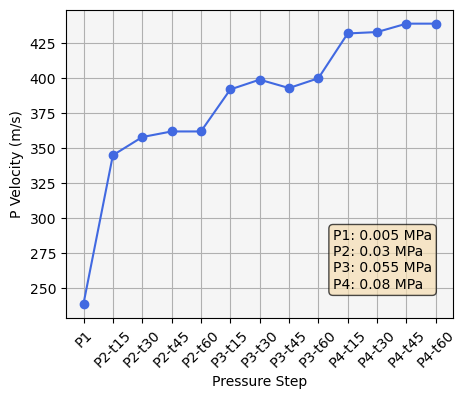

In [8]:
"""
Plot Velocity over time for pressure samples, showing how picked
velocity became stable relatively quickly after loading. This justifies
using shortened (~1 hour) stabilization times between measurements.
"""

## 3 time steps for each pressure
p_0kg = [239]
p_2kg = [345, 358, 362, 362]
p_4kg = [392, 399, 393, 400]
p_6kg = [432, 433, 439, 439]
_tmp_vels = [p_0kg, p_2kg, p_4kg, p_6kg]

## Make plot labels
_tmp_pres_labs = ["P2-", "P3-", "P4-"]
times = ["t15", "t30", "t45", "t60"]
plot_labels = ["P1"]
for _p in _tmp_pres_labs:
    for _t in times:
        plot_labels.append(_p+_t)
all_vels = [item for sublist in _tmp_vels for item in sublist]

plt.figure(figsize=(5,4))
plt.plot(all_vels, "-o", color="royalblue")
plt.gca().set(ylabel="P Velocity (m/s)",
              xlabel="Pressure Step",
             axisbelow=True,
             facecolor="whitesmoke")
plt.grid("both")
plt.xticks(np.arange(0,13,1),plot_labels, rotation=45)
overlay_text = "P1: 0.005 MPa\nP2: 0.03 MPa\nP3: 0.055 MPa\nP4: 0.08 MPa"
props = dict(boxstyle="round", facecolor="wheat", alpha=0.7)
plt.text(8.5,250,overlay_text, bbox=props)
plt.show()

C:\Users\amos\miniconda3\envs\cadiss\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


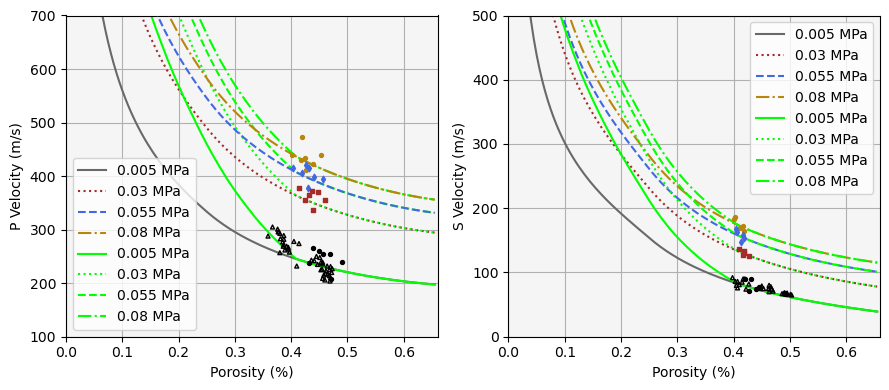

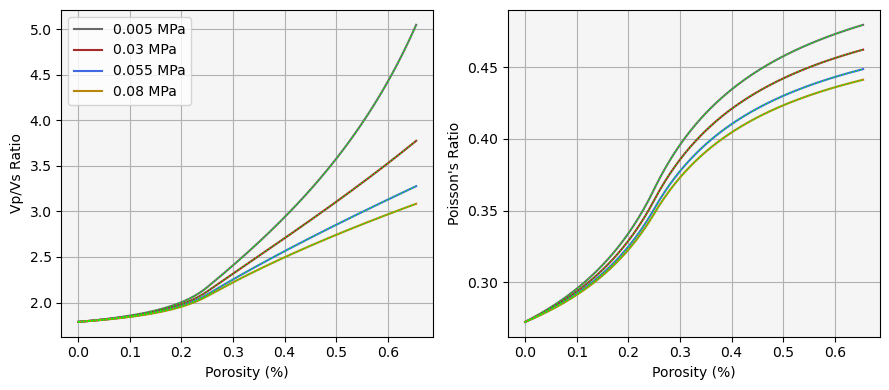

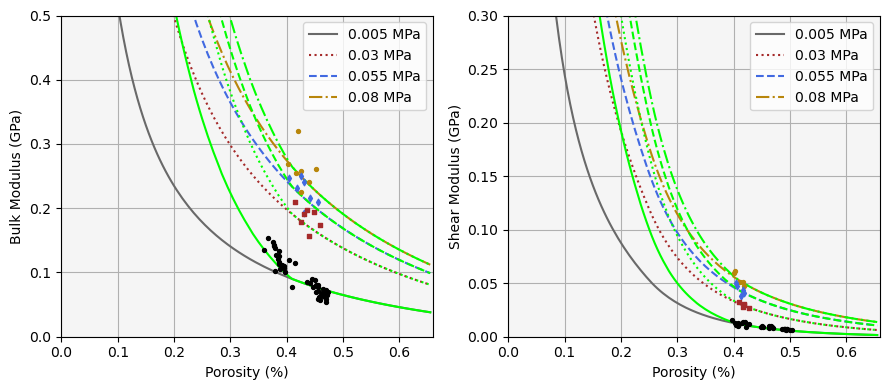

In [5]:
"""
Load picked velocity for the 4 pressure steps and plot against
the Rock Physics Model.

The "fitting PR" was calculated from average velocity values
at each pressure step, and then used to calculate the modeled
effective shear modulus for each pressure.

Note that parameters for the modified HM do not have to be altered
for each pressure, giving confidence that the model is robust within 
the sampled pressure range.
"""


## Model Parameters
por_range = np.arange(0,critical_porosity, 0.005)

## Calculate RP models
press_bulk_mods = []
press_shear_mods = []
press_bulk_mods_amos = []
press_shear_mods_amos = []
vp_uncem = []
vs_uncem = []
vp_amos = []
vs_amos = []

for por in por_range:
    # C = rp.upper_murphy(por)
    # C = rp.lower_murphy_bounded(por)
    # C = rp.modified_murphy(por)
    C = 3
    dens = eff_min_density*(1-por)

    tmp_vp = []
    tmp_vs = []
    tmp_vp_amos = []
    tmp_vs_amos = []
    tmp_k = []
    tmp_mu = []
    tmp_k_amos = []
    tmp_mu_amos = []
    for pressure, max_poisson, contact_ratio in zip(pressures, max_poisson_list, contact_ratios):
        keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)
        keff_uncem, ueff_uncem = rp.amos_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=max_poisson)
        keff_amos, ueff_amos = rp.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=max_poisson,
                                           trans_por=0.41)
        
        tmp_vp.append(rp.p_vel_mod(keff_uncem, ueff_uncem, dens)*1000)
        tmp_vs.append(rp.s_vel_mod(ueff_uncem, dens)*1000)
        tmp_vp_amos.append(rp.p_vel_mod(keff_amos, ueff_amos, dens)*1000)
        tmp_vs_amos.append(rp.s_vel_mod(ueff_amos, dens)*1000)
        tmp_k.append(keff_uncem)
        tmp_mu.append(ueff_uncem)
        tmp_k_amos.append(keff_amos)
        tmp_mu_amos.append(ueff_amos)
    vp_uncem.append(tmp_vp)
    vs_uncem.append(tmp_vs)
    vp_amos.append(tmp_vp_amos)
    vs_amos.append(tmp_vs_amos)
    press_bulk_mods.append(tmp_k)
    press_shear_mods.append(tmp_mu)
    press_bulk_mods_amos.append(tmp_k_amos)
    press_shear_mods_amos.append(tmp_mu_amos)

vp_uncem = np.array(vp_uncem)
vs_uncem = np.array(vs_uncem)
vp_amos = np.array(vp_amos)
vs_amos = np.array(vs_amos)
press_bulk_mods = np.array(press_bulk_mods)
press_shear_mods = np.array(press_shear_mods)
press_bulk_mods_amos = np.array(press_bulk_mods_amos)
press_shear_mods_amos = np.array(press_shear_mods_amos)


## CALCULATE MODULI FROM MEASUREMENTS
shear_moduli_p0 = []
for vs, dens in zip(data_s[:,0], data_s[:,1]):
    shear_moduli_p0.append(rp.shear_mod(vs, dens)/1000000)
vs_fit = np.poly1d(np.polyfit(data_s[:,2], data_s[:,0], deg=1))  #linear fit to VS/por
bulk_moduli_p0 = []
for vp, dens, por in zip(data_p[:,0], data_p[:,1], data_p[:,2]):
    vs = vs_fit(por)
    bulk_moduli_p0.append(rp.bulk_mod(vp, vs, dens)/1000000)

shear_moduli_p1 = []
for vs, dens in zip(pres_step_1_s[:,0], pres_step_1_s[:,1]):
    shear_moduli_p1.append(rp.shear_mod(vs, dens)/1000000)
shear_moduli_p2 = []
for vs, dens in zip(pres_step_2_s[:,0], pres_step_2_s[:,1]):
    shear_moduli_p2.append(rp.shear_mod(vs, dens)/1000000)
shear_moduli_p3 = []
for vs, dens in zip(pres_step_3_s[:,0], pres_step_3_s[:,1]):
    shear_moduli_p3.append(rp.shear_mod(vs, dens)/1000000)

# use modeled Vs to calculate Bulk Mod
bulk_moduli_p1 = []
bulk_moduli_p2 = []
bulk_moduli_p3 = []
for vp, dens, por in zip(pres_step_1_p[:,0], pres_step_1_p[:,1], pres_step_1_p[:,2]):
    tmp_idx = (np.abs(por_range-por)).argmin()
    vs = vs_amos[tmp_idx, 1]
    bulk_moduli_p1.append(rp.bulk_mod(vp, vs, dens)/1000000)
for vp, dens, por in zip(pres_step_2_p[:,0], pres_step_2_p[:,1], pres_step_2_p[:,2]):
    tmp_idx = (np.abs(por_range-por)).argmin()
    vs = vs_amos[tmp_idx, 2]
    bulk_moduli_p2.append(rp.bulk_mod(vp, vs, dens)/1000000)
for vp, dens, por in zip(pres_step_3_p[:,0], pres_step_3_p[:,1], pres_step_3_p[:,2]):
    tmp_idx = (np.abs(por_range-por)).argmin()
    vs = vs_amos[tmp_idx, 3]
    bulk_moduli_p3.append(rp.bulk_mod(vp, vs, dens)/1000000)
    

##----------------------------------
## PLOTS

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
dot_size = 8
ax[0].plot(por_range, vp_uncem[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color=pres_colors[0], zorder=1)
ax[0].plot(por_range, vp_uncem[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color=pres_colors[1], ls=":", zorder=2)
ax[0].plot(por_range, vp_uncem[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2], ls="--", zorder=3)
ax[0].plot(por_range, vp_uncem[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3], ls="-.", zorder=4)
ax[0].scatter(pres_step_0_p[:,2], pres_step_0_p[:,0], s=dot_size, color="black", zorder=100)
ax[0].scatter(pres_step_1_p[:,2], pres_step_1_p[:,0], s=dot_size, color=pres_colors[1],
              marker="s", zorder=99)
ax[0].scatter(pres_step_2_p[:,2], pres_step_2_p[:,0], s=dot_size+3, color=pres_colors[2],
               marker="d", zorder=98)
ax[0].scatter(pres_step_3_p[:,2], pres_step_3_p[:,0], s=dot_size, color=pres_colors[3], zorder=97)
ax[0].scatter(data_p[:,2], data_p[:,0], s=dot_size, edgecolors="black", 
              facecolors="none", marker="^", zorder=50)

ax[0].plot(por_range, vp_amos[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color="lime")
ax[0].plot(por_range, vp_amos[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color="lime", ls=":")
ax[0].plot(por_range, vp_amos[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color="lime", ls="--")
ax[0].plot(por_range, vp_amos[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color="lime", ls="-.")

ax[0].legend()
ax[0].set(xlim=(0., round(critical_porosity,2)),
         ylim=(100,700),
          # ylim=(0,3000),
         xlabel="Porosity (%)",
         ylabel="P Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].grid("both")

ax[1].plot(por_range, vs_uncem[:,0], label=str(round(pressures[0]*1000,3))+" MPa", color=pres_colors[0])
ax[1].plot(por_range, vs_uncem[:,1], label=str(round(pressures[1]*1000,3))+" MPa",
           color=pres_colors[1], ls=":")
ax[1].plot(por_range, vs_uncem[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2], ls="--")
ax[1].plot(por_range, vs_uncem[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3], ls="-.")
ax[1].scatter(pres_step_0_s[:,2], pres_step_0_s[:,0], s=dot_size, color="black", zorder=100)
ax[1].scatter(pres_step_1_s[:,2], pres_step_1_s[:,0], s=dot_size, color=pres_colors[1], 
              marker="s", zorder=99)
ax[1].scatter(pres_step_2_s[:,2], pres_step_2_s[:,0], s=dot_size+3, color=pres_colors[2], 
               marker="d", zorder=98)
ax[1].scatter(pres_step_3_s[:,2], pres_step_3_s[:,0], s=dot_size, color=pres_colors[3], zorder=97)
ax[1].scatter(data_s[:,2], data_s[:,0], s=dot_size, edgecolors="black", 
              facecolors="none", marker="^", zorder=50)

ax[1].plot(por_range, vs_amos[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color="lime")
ax[1].plot(por_range, vs_amos[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color="lime", ls=":")
ax[1].plot(por_range, vs_amos[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color="lime", ls="--")
ax[1].plot(por_range, vs_amos[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color="lime", ls="-.")

ax[1].legend()
ax[1].set(xlim=(0., round(critical_porosity,2)),
         ylim=(0,500),
          # ylim=(0,1500),
         xlabel="Porosity (%)",
         ylabel="S Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].grid("both")

plt.tight_layout()
plt.show()

## PR and VpVs plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax[0].plot(por_range, vp_uncem[:,0]/vs_uncem[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color=pres_colors[0])
ax[0].plot(por_range, vp_uncem[:,1]/vs_uncem[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color=pres_colors[1])
ax[0].plot(por_range, vp_uncem[:,2]/vs_uncem[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2])
ax[0].plot(por_range, vp_uncem[:,3]/vs_uncem[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3])
ax[0].plot(por_range, vp_amos[:,0]/vs_amos[:,0], color="lime", lw=0.9, ls=":")
ax[0].plot(por_range, vp_amos[:,1]/vs_amos[:,1], color="lime", lw=0.9, ls=":")
ax[0].plot(por_range, vp_amos[:,2]/vs_amos[:,2], color="lime", lw=0.9, ls=":")
ax[0].plot(por_range, vp_amos[:,3]/vs_amos[:,3], color="lime", lw=0.9, ls=":")
ax[0].legend()
ax[0].set(xlabel="Porosity (%)",
         ylabel="Vp/Vs Ratio",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].grid("both")

ax[1].plot(por_range, rp.poisson_vel(vp_uncem[:,0],vs_uncem[:,0]), label=str(round(pressures[0]*1000,3))+" MPa", 
           color=pres_colors[0])
ax[1].plot(por_range, rp.poisson_vel(vp_uncem[:,1],vs_uncem[:,1]), label=str(round(pressures[1]*1000,3))+" MPa", 
           color=pres_colors[1])
ax[1].plot(por_range, rp.poisson_vel(vp_uncem[:,2],vs_uncem[:,2]), label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2])
ax[1].plot(por_range, rp.poisson_vel(vp_uncem[:,3],vs_uncem[:,3]), label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3])
ax[1].plot(por_range, rp.poisson_vel(vp_amos[:,0],vs_amos[:,0]), color="lime", lw=0.9, ls=":")
ax[1].plot(por_range, rp.poisson_vel(vp_amos[:,1],vs_amos[:,1]), color="lime", lw=0.9, ls=":")
ax[1].plot(por_range, rp.poisson_vel(vp_amos[:,2],vs_amos[:,2]), color="lime", lw=0.9, ls=":")
ax[1].plot(por_range, rp.poisson_vel(vp_amos[:,3],vs_amos[:,3]), color="lime", lw=0.9, ls=":")
ax[1].set(xlabel="Porosity (%)",
         ylabel="Poisson's Ratio",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].grid("both")


plt.tight_layout()
plt.show()


## Moduli plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

ax[0].plot(por_range, press_bulk_mods[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color=pres_colors[0])
ax[0].plot(por_range, press_bulk_mods[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color=pres_colors[1], ls=":")
ax[0].plot(por_range, press_bulk_mods[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2], ls="--")
ax[0].plot(por_range, press_bulk_mods[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3], ls="-.")
ax[0].plot(por_range, press_bulk_mods_amos[:,0],  color="lime")
ax[0].plot(por_range, press_bulk_mods_amos[:,1],  color="lime", ls=":")
ax[0].plot(por_range, press_bulk_mods_amos[:,2], color="lime", ls="--")
ax[0].plot(por_range, press_bulk_mods_amos[:,3], color="lime", ls="-.")
ax[0].scatter(data_p[:,2], bulk_moduli_p0, s=dot_size, color="black", zorder=100)
ax[0].scatter(pres_step_1_p[:,2], bulk_moduli_p1, s=dot_size, color=pres_colors[1],
              marker="s", zorder=99)
ax[0].scatter(pres_step_2_p[:,2], bulk_moduli_p2, s=dot_size+3, color=pres_colors[2],
               marker="d", zorder=98)
ax[0].scatter(pres_step_3_p[:,2], bulk_moduli_p3, s=dot_size, color=pres_colors[3], zorder=97)
ax[0].legend()
ax[0].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.5),
          xlabel="Porosity (%)",
         ylabel="Bulk Modulus (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].grid("both")

ax[1].plot(por_range, press_shear_mods[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color=pres_colors[0])
ax[1].plot(por_range, press_shear_mods[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color=pres_colors[1], ls=":")
ax[1].plot(por_range, press_shear_mods[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color=pres_colors[2], ls="--")
ax[1].plot(por_range, press_shear_mods[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color=pres_colors[3], ls="-.")
ax[1].plot(por_range, press_shear_mods_amos[:,0],  color="lime")
ax[1].plot(por_range, press_shear_mods_amos[:,1],  color="lime", ls=":")
ax[1].plot(por_range, press_shear_mods_amos[:,2], color="lime", ls="--")
ax[1].plot(por_range, press_shear_mods_amos[:,3], color="lime", ls="-.")
ax[1].scatter(data_s[:,2], shear_moduli_p0, s=dot_size, color="black", zorder=100)
ax[1].scatter(pres_step_1_s[:,2], shear_moduli_p1, s=dot_size, color=pres_colors[1], 
              marker="s", zorder=99)
ax[1].scatter(pres_step_2_s[:,2], shear_moduli_p2, s=dot_size+3, color=pres_colors[2], 
               marker="d", zorder=98)
ax[1].scatter(pres_step_3_s[:,2], shear_moduli_p3, s=dot_size, color=pres_colors[3], zorder=97)
ax[1].legend()
ax[1].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.3),
          xlabel="Porosity (%)",
         ylabel="Shear Modulus (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].grid("both")

plt.tight_layout()
plt.show()

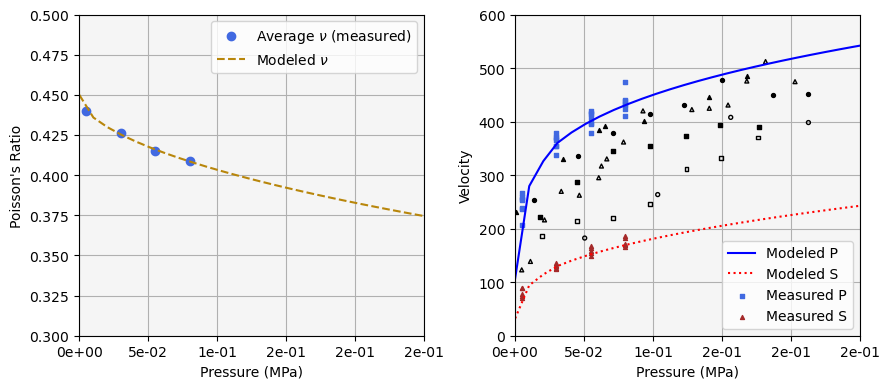

In [9]:
"""
Investigate the pressure-PR relationship established 
by fitting models above in order to calculate the 
"fitting PR" for a given pressure/depth.

Plot PR calculated from RPM over given pressure range
at a constant porosity.

Plot Vp and Vs against pressure. Add measured data points,
but note that they don't strictly correspond to this porosity
leading to a slight visual disconnect with the above pressure
plots (would be akin to projecting above points to 0.41 porosity)
"""

pres_range = np.linspace(0.0000001,0.0005, 50)

## Perform polynomial fit to average PR values from measurements
## Add near-intercept point to control fit
_fitpres = np.insert(pressures, 0, 0.0000001)
_fitpr = np.insert(max_poisson_list, 0, 0.45) 
pr_fit = np.poly1d(np.polyfit(_fitpres**(1/10), _fitpr, deg=3))
est_pr = []
for p in pres_range:
    est_pr.append(pr_fit(p**(1/10)))

## Calculate PR values from standard and B&A HM using Uncemented model
por_calc = fitting_por  # based on avg. por from pressure measurements
dens = eff_min_density*(1-por_calc)
C = 3
est_pr_hm = []
est_pr_amos = []
vp_amos = []
vs_amos = []
power_1_6 = []
for p in pres_range:
    ## Estimate a contact ratio based on pressure
    if p <= pressures[0]:
        tmp_p_range = np.linspace(0, pressures[0], 100)
        tmp_p_idx = (np.abs(tmp_p_range - p)).argmin()
        tmp_cr_range = np.linspace(0.2, contact_ratios[0], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    elif pressures[0] < p <= pressures[1]:
        tmp_p_range = np.linspace(pressures[0], pressures[1], 100)
        tmp_p_idx = (np.abs(tmp_p_range - p)).argmin()
        tmp_cr_range = np.linspace(contact_ratios[0], contact_ratios[1], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    else:
        contact_ratio = contact_ratios[-1]

    
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         p, c_ratio = contact_ratio, slip_percent = slip_percent)
    k_amos, u_amos = rp.amos_isoframe_model(por_calc, critical_porosity, keff, ueff, 
                                        effective_mineral_k, effective_mineral_u, 
                                     fit_por = por_calc, max_poisson=pr_fit(p**(1/10)),
                                           trans_por=0.41)  
    hm_pr_amos = rp.poisson_mod(k_amos, u_amos)
    est_pr_amos.append(hm_pr_amos)

    vp_amos.append(rp.p_vel_mod(k_amos, u_amos, dens)*1000)
    vs_amos.append(rp.s_vel_mod(u_amos, dens)*1000)


    ## Add a 1/6 power curve
    power_1_6.append(300*((p)/0.0001)**(1/6.))


## Optionally plot the data from Johnson's measurements on Apollo samples
plot_johnson = True   #whether to add to plot
d1, d2, d3, d4 = 1.29, 1.39, 1.53, 1.87 #reported sample densities
d1_load = johnson_data[(johnson_data[:,0]==1)&(johnson_data[:,1]==d1)]
d1_unload = johnson_data[(johnson_data[:,0]==1)&(johnson_data[:,1]==d4)]
d2_load = johnson_data[(johnson_data[:,0]==2)&(johnson_data[:,1]==d2)]
d2_unload = johnson_data[(johnson_data[:,0]==2)&(johnson_data[:,1]==d4)]
d3_load = johnson_data[(johnson_data[:,0]==3)&(johnson_data[:,1]==d3)]
d3_unload = johnson_data[(johnson_data[:,0]==3)&(johnson_data[:,1]==d4)]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax[0].scatter([i*1000 for i in pressures], max_poisson_list, 
            c='royalblue', label=("Average {} (measured)".format(r'$\nu$')))
ax[0].plot(pres_range*1000, est_pr_amos, color="darkgoldenrod", ls="--", label=("Modeled "+ r"$\nu$"))
ax[0].grid("both")
ax[0].legend()
# ax[0].set_xticks(rotation=45)
ax[0].xaxis.set_major_formatter(major_formatter)
ax[0].set(xlabel="Pressure (MPa)",
              ylabel="Poisson's Ratio",
              ylim = (0.3, 0.5),
              # xlim=(0, pres_range[-1]*1000),
              xlim=(0, 2.5e-1),
              axisbelow=True,
              facecolor="whitesmoke")  

dot_size = 8
ax[1].plot(pres_range*1000, vp_amos, color="blue", label="Modeled P")
ax[1].plot(pres_range*1000, vs_amos, ":", color="red", label="Modeled S")
# ax[1].plot(pres_range*1000, power_1_6, "--", color="brown", label="1/6 Power")
ax[1].scatter(pres_step_0_p[:,3], pres_step_0_p[:,0], s=dot_size, color="royalblue",
              marker="s", label="Measured P")
ax[1].scatter(pres_step_1_p[:,3], pres_step_1_p[:,0], s=dot_size, color="royalblue", marker="s")
ax[1].scatter(pres_step_2_p[:,3], pres_step_2_p[:,0], s=dot_size, color="royalblue", marker="s")
ax[1].scatter(pres_step_3_p[:,3], pres_step_3_p[:,0], s=dot_size, color="royalblue", marker="s")
ax[1].scatter(pres_step_0_s[:,3], pres_step_0_s[:,0], s=dot_size, color="brown",
              marker="^", label="Measured S")
ax[1].scatter(pres_step_1_s[:,3], pres_step_1_s[:,0], s=dot_size, color="brown", marker="^")
ax[1].scatter(pres_step_2_s[:,3], pres_step_2_s[:,0], s=dot_size, color="brown", marker="^")
ax[1].scatter(pres_step_3_s[:,3], pres_step_3_s[:,0], s=dot_size, color="brown", marker="^")

if plot_johnson:
    ax[1].scatter(d1_load[:,2], d1_load[:,-1], s=dot_size, color="black", marker="s", facecolors="none")
    ax[1].scatter(d1_unload[:,2], d1_unload[:,-1], s=dot_size, color="black", marker="s", facecolors="black")
    ax[1].scatter(d2_load[:,2], d2_load[:,-1], s=dot_size, color="black", marker="^", facecolors="none")
    ax[1].scatter(d2_unload[:,2], d2_unload[:,-1], s=dot_size, color="black", marker="^", facecolors="black")
    ax[1].scatter(d3_load[:,2], d3_load[:,-1], s=dot_size, color="black", marker="o", facecolors="none")
    ax[1].scatter(d3_unload[:,2], d3_unload[:,-1], s=dot_size, color="black", marker="o", facecolors="black")

ax[1].grid("both")
ax[1].legend()
# ax[1].set_xticks(rotation=45)
ax[1].xaxis.set_major_formatter(major_formatter)
ax[1].set(xlabel="Pressure (MPa)",
              ylabel="Velocity",
              ylim = (0., 600),
              # xlim=(0, pres_range[-1]*1000),
              xlim=(0, 2.5e-1),
              axisbelow=True,
              facecolor="whitesmoke")

plt.tight_layout()
plt.show()

## Sample-limited "combined" dataset

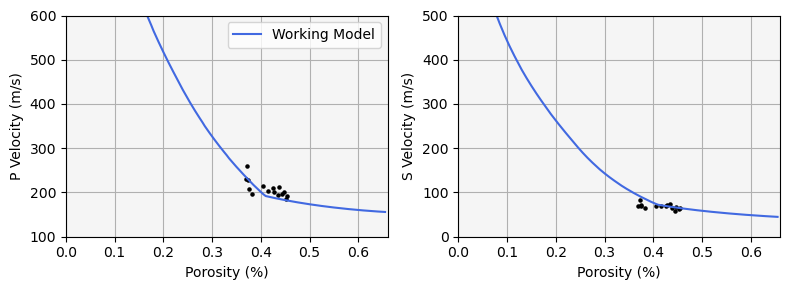

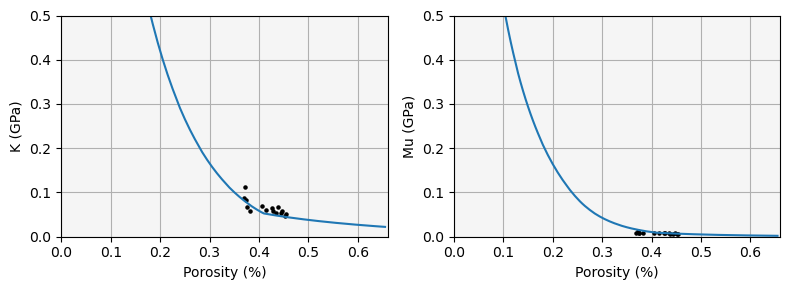

In [10]:
"""
A second sample chamber was constructed for easier transfer of the regolith sample,
allowing both P and S measurements on the exact same sample. Some sample hysteresis
is still expected. Pressure measurements could not be taken with this combined chamber,
so assume Pressure-PR relationship from above 

Initial observations are that the measured velocities are slower than those taken 
with the primary sample chamber. It is still unclear what causes this difference.

Investigate whether these slower velocities better match the observed Lunar velocities
"""

data_p_comb = data_comb[:, [0,2,3]]
data_s_comb = data_comb[:, [1,2,3]]

## Model Parameters
pressure = pressures[0]  #GPa for calculations
max_poisson_combined = 0.42  #average from measurements

## Calculate RP models, modify the model parameters used above
por_range = np.arange(0,critical_porosity, 0.005)
cr_combined = 0.1
slip_combined = 0.5


vp_amos = []
vs_amos = []
k_amos = []
mu_amos = []

for por in por_range:
    C = 3
    dens = eff_min_density*(1-por)
    
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     pressure, c_ratio = cr_combined, slip_percent = slip_combined)
    keff_amos, ueff_amos = rp.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u, 
                                            max_poisson=max_poisson_combined, fit_por=fitting_por,
                                                   trans_por=0.41)

    vp_amos.append(rp.p_vel_mod(keff_amos, ueff_amos, dens)*1000)
    vs_amos.append(rp.s_vel_mod(ueff_amos, dens)*1000)
    k_amos.append(keff_amos)
    mu_amos.append(ueff_amos)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
ax[0].scatter(data_p_comb[:,2], data_p_comb[:,0], s=5, color="black")
ax[0].plot(por_range, vp_amos, label="Working Model", color="royalblue")
ax[0].legend()
ax[0].set(xlim=(0., round(critical_porosity,2)),
         ylim=(100,600),
         xlabel="Porosity (%)",
         ylabel="P Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].grid("both")

ax[1].scatter(data_s_comb[:,2], data_s_comb[:,0], s=5, color="black")
ax[1].plot(por_range, vs_amos, label="Working Model", color="royalblue")
# ax[1].legend()
ax[1].set(xlim=(0., round(critical_porosity,2)),
         ylim=(0,500),
         xlabel="Porosity (%)",
         ylabel="S Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].grid("both")

plt.tight_layout()
plt.show()

## CALCULATE MODULI
shear_moduli = []
for vs, dens in zip(data_s_comb[:,0], data_s_comb[:,1]):
    shear_moduli.append(rp.shear_mod(vs, dens)/1000000)
vs_fit = np.poly1d(np.polyfit(data_s_comb[:,2], data_s_comb[:,0], deg=1))  #linear fit to VS/por
bulk_moduli = []
for vp, dens, por in zip(data_p_comb[:,0], data_p_comb[:,1], data_p_comb[:,2]):
    vs = vs_fit(por)
    bulk_moduli.append(rp.bulk_mod(vp, vs, dens)/1000000)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
ax[0].plot(por_range,k_amos)
ax[0].scatter(data_p_comb[:,2], bulk_moduli, s=5, color="black")
ax[0].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.5),
         xlabel="Porosity (%)",
         ylabel="K (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].grid("both")

ax[1].plot(por_range,mu_amos)
ax[1].scatter(data_s_comb[:,2], shear_moduli, s=5, color="black")
ax[1].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.5),
         xlabel="Porosity (%)",
         ylabel="Mu (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].grid("both")

plt.tight_layout()
plt.show()

## Define density/porosity profile for lunar regolith, model velocity profiles

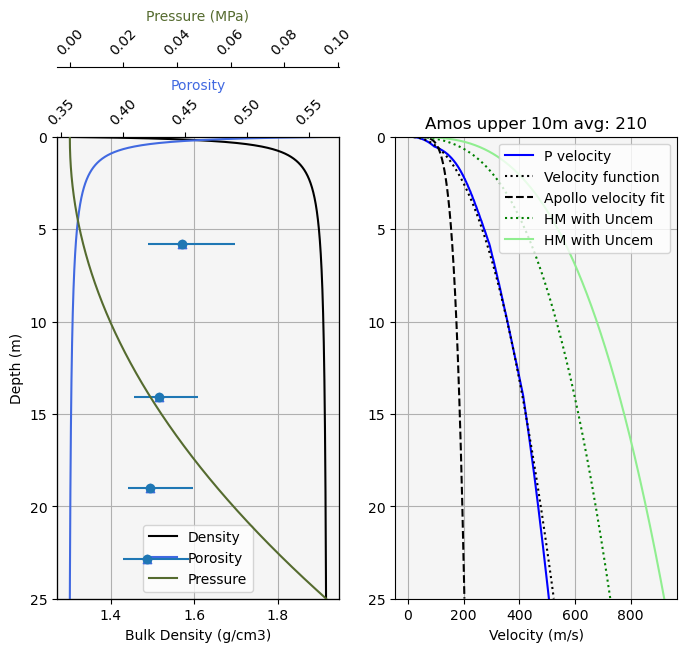

In [13]:
"""
Note discrepancy between lab measured porosity (density) and
that calculated from Lunar Sourcebook relationships. If we assume
the calculated in situ values are correct, then some form 
of additional porosity reduction technique (ultrasonic vibration?)
could help 
"""
##  SUBSURFACE PROPERTIES
##  POROSITY, DENSITY, PRESSURE PROFILES

## Acceleration due to gravity, in m/s
grav_accel = 1.625

## Specific gravity of regolith
specific_gravity = eff_min_density
# specific_gravity = 3.1  #value from lunar sourcebook

## Depth range, in m
max_depth = 25
depth_step = 0.01
depths = np.arange(0,max_depth,depth_step)

## Density equation from Lunar Sourcebook, in g/cm3, page 494
densities = 1.92 * ((depths*100 + 12.2)/(depths*100 + 18))
# densities = np.array([1.68]*len(depths))  # trying constant value that fits shallow core

## Porosity equation from Lunar Sourcebook
porosities = 1 - (densities / specific_gravity)

## Pressure, in MPa
integrated_density = integrate.cumulative_trapezoid(densities)
ss_pressures = np.cumsum((grav_accel * integrated_density * depth_step) / 1e6)
ss_pressures = np.hstack((0, ss_pressures))

## Calculate velocity using model parameters established above and these
## porosity/pressure profiles
vp_amos = []
vs_amos = []
# vp_uncem_comb = []
# vs_uncem_comb = []
vp_apollo_fit = []
vp_hm = []
for por, pressure, dens in zip(porosities, ss_pressures, densities):
    if pressure==0:
        continue
    ## Change pressure to GPa
    pressure = pressure/1000
    
    # C = rp.lower_murphy_bounded(por)
    # C = rp.upper_murphy(por)
    C = 3

    ## Estimate a contact ratio based on pressure
    if pressure <= pressures[0]:
        tmp_p_range = np.linspace(0, pressures[0], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(0.25, contact_ratios[0], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    elif pressures[0] < pressure <= pressures[1]:
        tmp_p_range = np.linspace(pressures[0], pressures[1], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(contact_ratios[0], contact_ratios[1], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    else:
        contact_ratio = contact_ratios[-1]

    ## Using model parameters derived from primary sample chamber
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)
    # keff_uncem, ueff_uncem = rp.amos_model(por, critical_porosity, keff, ueff, 
    #                                         effective_mineral_k, effective_mineral_u, 
    #                                         max_poisson=pr_fit(pressure**(1/10)), fit_por=fitting_por)
    keff_amos, ueff_amos = rp.amos_isoframe_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por, max_poisson=pr_fit(pressure**(1/10)),
                                           trans_por=0.41)
    vp_amos.append(rp.p_vel_mod(keff_amos, ueff_amos, dens)*1000)
    vs_amos.append(rp.s_vel_mod(ueff_amos, dens)*1000)

    # ## Using model parameters derived from combined sample chamber
    # ## NOTE: these data display higher PR values, so the PR fit may be invalid
    # keff_comb, ueff_comb = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
    #                                      pressure, c_ratio = cr_combined, slip_percent = slip_combined)
    # keff_uncem_comb, ueff_uncem_comb = rp.amos_model(por, critical_porosity, keff_comb, ueff_comb, 
    #                                         effective_mineral_k, effective_mineral_u, 
    #                                         max_poisson=pr_fit(pressure**(1/10)), fit_por=fitting_por)
    # vp_uncem_comb.append(rp.p_vel_mod(keff_uncem_comb, ueff_uncem_comb, dens)*1000)
    # vs_uncem_comb.append(rp.s_vel_mod(ueff_uncem_comb, dens)*1000)

    ## Try to fit Apollo data, use HM parameters for fit
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = 0.016, slip_percent = 0.3)
    k_apollo, u_apollo = rp.amos_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u, 
                                            max_poisson=pr_fit(pressure**(1/10)), fit_por=fitting_por)
    vp_apollo_fit.append(rp.p_vel_mod(k_apollo, u_apollo, dens)*1000)

    ## Plot what a basic HM contact with Uncem Model would look like
    keff, ueff = rp.hertz_mindlin(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     pressure, f=1)
    keff_hm, ueff_hm = rp.uncemented_model(por, critical_porosity, keff, ueff, 
                                              effective_mineral_k, effective_mineral_u)
    vp_hm.append(rp.p_vel_mod(keff_hm, ueff_hm, dens)*1000)
    
vp_amos = np.hstack((np.nan, np.array(vp_amos)))
vs_amos = np.hstack((np.nan, np.array(vs_amos)))
# vp_uncem_comb = np.hstack((np.nan, np.array(vp_uncem_comb)))
# vs_uncem_comb = np.hstack((np.nan, np.array(vs_uncem_comb)))
vp_apollo_fit = np.hstack((np.nan, np.array(vp_apollo_fit)))
vp_hm = np.hstack((np.nan, np.array(vp_hm)))

## Grab experimental density and porosity data for plotting
pres0 = pres_step_0_p[0,3]
pres1 = pres_step_1_p[0,3]
pres2 = pres_step_2_p[0,3]
pres3 = pres_step_3_p[0,3]
pres0_idx = (np.abs(ss_pressures - pres0)).argmin()
pres1_idx = (np.abs(ss_pressures - pres1)).argmin()
pres2_idx = (np.abs(ss_pressures - pres2)).argmin()
pres3_idx = (np.abs(ss_pressures - pres3)).argmin()
pres_depths = np.array([depths[pres0_idx], depths[pres1_idx], depths[pres2_idx], depths[pres3_idx]])

pres0_dens = np.mean(np.concatenate((pres_step_0_p[:,1], pres_step_0_s[:,1])))
pres1_dens = np.mean(np.concatenate((pres_step_1_p[:,1], pres_step_1_s[:,1])))
pres2_dens = np.mean(np.concatenate((pres_step_2_p[:,1], pres_step_2_s[:,1])))
pres3_dens = np.mean(np.concatenate((pres_step_3_p[:,1], pres_step_3_s[:,1])))
pres_densities = np.array([pres0_dens ,pres1_dens, pres2_dens, pres3_dens])

pres0_por = np.mean(np.concatenate((pres_step_0_p[:,2], pres_step_0_s[:,2])))
pres1_por = np.mean(np.concatenate((pres_step_1_p[:,2], pres_step_1_s[:,2])))
pres2_por = np.mean(np.concatenate((pres_step_2_p[:,2], pres_step_2_s[:,2])))
pres3_por = np.mean(np.concatenate((pres_step_3_p[:,2], pres_step_3_s[:,2])))
pres_porosities = np.array([pres0_por, pres1_por, pres2_por, pres3_por])

pres0_por_min = np.amin(np.concatenate((pres_step_0_p[:,2], pres_step_0_s[:,2])))
pres1_por_min = np.amin(np.concatenate((pres_step_1_p[:,2], pres_step_1_s[:,2])))
pres2_por_min = np.amin(np.concatenate((pres_step_2_p[:,2], pres_step_2_s[:,2])))
pres3_por_min = np.amin(np.concatenate((pres_step_3_p[:,2], pres_step_3_s[:,2])))
pres_porosities_min = np.array([pres0_por_min, pres1_por_min, pres2_por_min, pres3_por_min])
pres_porosities_min = np.abs(pres_porosities-pres_porosities_min)

pres0_por_max = np.amax(np.concatenate((pres_step_0_p[:,2], pres_step_0_s[:,2])))
pres1_por_max = np.amax(np.concatenate((pres_step_1_p[:,2], pres_step_1_s[:,2])))
pres2_por_max = np.amax(np.concatenate((pres_step_2_p[:,2], pres_step_2_s[:,2])))
pres3_por_max = np.amax(np.concatenate((pres_step_3_p[:,2], pres_step_3_s[:,2])))
pres_porosities_max = np.array([pres0_por_max, pres1_por_max, pres2_por_max, pres3_por_max])
pres_porosities_max = np.abs(pres_porosities-pres_porosities_max)

por_minmax = [pres_porosities_min, pres_porosities_max]


## Try to define a velocity-depth equation
def amos_vp(depth):
    multiplier = 1.5
    divider = 0.000022
    power = 0.42
    vel = multiplier * (depth/divider)**power
    return vel

# def amos_vp_disp(depth):
#     """
#     Add arbitrary depth-dependent dispersion fudge factor
#     """
#     ## Create arbitrary dispersion curve
#     disp_curve = [(0.0001,1), (10, 0.8), (30, 0.7)]
#     depth_fits = []
#     disp_fits = []
#     for disp in disp_curve:
#         depth_fits.append(disp[0])
#         disp_fits.append(disp[1])
#     disp_fit = np.poly1d(np.polyfit(np.log(depth_fits), disp_fits, deg=2))
#     disp = disp_fit(np.log(depth))

#     ## velocity function
#     multiplier = 1.5
#     divider = 0.000022
#     power = 0.42
#     vel = multiplier * (depth/divider)**power

#     # for i, disp_pair in enumerate(disp_curve):
#     #     tmp_depth = disp_pair[0]
#     #     forward_depth = disp_curve[i+1][0]
#     #     if depth >= forward_depth:
#     #         continue
#     #     if (depth < forward_depth):
#     #         disp = disp_pair[1]
#     #         break
#     vel = vel*disp
#     return vel

def apollo_vel(depth):
    vel = 55 * ((depth)/0.01)**(1/6.)
    return vel

def apollo_fit_vel(depth):
    """
    Use the BA model +PR fit, adjust RP model parameters
    (i.e. contact ratio) to try to make a velocity
    profile that is consistent with Apollo observations
    """
    multiplier = 1.5
    divider = 0.000004
    power = 0.35
    vel = multiplier * (depth/divider)**power
    return vel

def hm_fit(depth):
    """
    Fitting the basic HM contact plus Uncem model
    to see what exponent is required
    """
    multiplier = 5
    divider = 0.000004
    power = 1/3
    vel = multiplier * (depth/divider)**power
    return vel

apollo_working = []
apollo_vels = []
amos_vels = []
hm_vels = []
# amos_vels_disp = []
for d in depths:
    # amos_vels.append(amos_vp(d))
    amos_vels.append(amos_vp(d))
    apollo_vels.append(apollo_vel(d))
    apollo_working.append(apollo_fit_vel(d))
    # amos_vels_disp.append(amos_vp_disp(d))
    hm_vels.append(hm_fit(d))


# amos_vels = np.array(amos_vels) * 0.7  #add fake anisotropy
## Upper 10 m average
cumu_times = [depth_step/i for i in amos_vels[1:np.where(depths==10)[0][0]]]
amos_10avg = round(10/np.sum(cumu_times))
    
## Pressure / Density / Porosity Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
y_lims = (max_depth,-0.01)

twin1 = ax[0].twiny()
twin2 = ax[0].twiny()
twin2.spines.top.set_position(("axes", 1.15))

dens_plot = ax[0].plot(densities, depths, label='Density', color='black')
por_plot = twin1.plot(porosities, depths, label='Porosity', color='royalblue')
pres_plot = twin2.plot(ss_pressures, depths, label='Pressure', color='darkolivegreen')
# ax[0].scatter(pres_densities, pres_depths, marker="^", color="black")
twin1.scatter(pres_porosities, pres_depths, marker="^", color='royalblue')
twin1.errorbar(pres_porosities, pres_depths, xerr=por_minmax, fmt="o")

twin1.tick_params(rotation=45)
twin2.tick_params(rotation=45)
ax[0].set_xlabel("Bulk Density (g/cm3)")
ax[0].set_ylabel("Depth (m)")
twin1.set_xlabel("Porosity")
twin2.set_xlabel("Pressure (MPa)")
ax[0].xaxis.label.set_color(dens_plot[0].get_color())
twin1.xaxis.label.set_color(por_plot[0].get_color())
twin2.xaxis.label.set_color(pres_plot[0].get_color())
ax[0].legend(handles=[dens_plot[0], por_plot[0], pres_plot[0]], loc='lower center')
ax[0].grid('both')
ax[0].set_facecolor('whitesmoke')
ax[0].set_ylim(y_lims[0],y_lims[1])

ax[1].plot(vp_amos, depths, label="P velocity", color="blue")
# ax[1].plot(vs_amos, depths, label="S velocity", color="red")
ax[1].plot(amos_vels, depths, ":", label="Velocity function", color="black")
# ax[1].plot(amos_vels_disp, depths, ":", label="Velocity function", color="green")
ax[1].plot(apollo_vels, depths, "--", label="Apollo velocity fit", color="black")
# ax[1].plot(vp_apollo_fit, depths, label="Apollo velocity model", color="cyan")
# ax[1].plot(apollo_working, depths, label="testing velocity model", color="magenta", ls="--")
# ax[1].plot(vp_uncem_comb, depths, ls="-.", label="P comb", color="blue")
# ax[1].plot(vs_uncem_comb, depths, ls="-.", label="S comb", color="red")
ax[1].plot(vp_hm, depths, ":", label="HM with Uncem", color="green")
ax[1].plot(hm_vels, depths, label="HM with Uncem", color="lightgreen")

ax[1].legend()
ax[1].set_xlabel("Velocity (m/s)")
ax[1].grid("both")
ax[1].set_facecolor('whitesmoke')
ax[1].set_ylim(y_lims[0],y_lims[1])
ax[1].set_title(f"Amos upper 10m avg: {amos_10avg}")

plt.show()

# Vacuum measurements

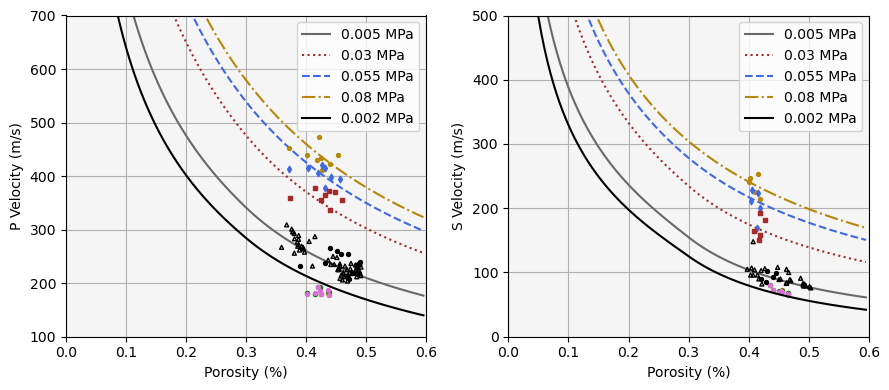

In [55]:
"""
Load P and S vacuum measurements, add to pressure-velocity plots

Note: high error expected in absolute values of vacuum velocity
measurements, so fit to model is expected to be low
"""

prevac_p = test_data_p_vacuum[np.where(test_data_p_vacuum[:,-1]==0)]
vac_p = test_data_p_vacuum[np.where(test_data_p_vacuum[:,-1]==1)]
postvac_p = test_data_p_vacuum[np.where(test_data_p_vacuum[:,-1]==2)]
prevac_s = test_data_s_vacuum[np.where(test_data_s_vacuum[:,-1]==0)]
vac_s = test_data_s_vacuum[np.where(test_data_s_vacuum[:,-1]==1)]
postvac_s = test_data_s_vacuum[np.where(test_data_s_vacuum[:,-1]==2)]

## Confining pressure estimate for vac holder
vac_pres = 0.0000022  #in GPa
vac_poisson = pr_fit(vac_pres**(1/10))
# vac_poisson = 0.407

## Generate plots exactly as before, add vacuum scatter points
## Model Parameters
por_range = np.arange(0,critical_porosity, 0.005)

## Calculate RP models
vp_uncem = []
vs_uncem = []
vp_vac = []
vs_vac = []

for por in por_range:
    C = rp.upper_murphy(por)
    dens = eff_min_density*(1-por)

    tmp_vp = []
    tmp_vs = []
    for pressure, max_poisson in zip(pressures, max_poisson_list):
        keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)
        keff_uncem, ueff_uncem = rp.amos_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u,
                                               fit_por = fitting_por,
                                            max_poisson=max_poisson)
        tmp_vp.append(rp.p_vel_mod(keff_uncem, ueff_uncem, dens)*1000)
        tmp_vs.append(rp.s_vel_mod(ueff_uncem, dens)*1000)
    vp_uncem.append(tmp_vp)
    vs_uncem.append(tmp_vs)

    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         vac_pres, c_ratio = 0.07, slip_percent = 0.)
    keff_vac, ueff_vac = rp.amos_model(por, critical_porosity, keff, ueff, 
                                        effective_mineral_k, effective_mineral_u,
                                           fit_por = fitting_por,
                                        max_poisson=vac_poisson)
    vp_vac.append(rp.p_vel_mod(keff_vac, ueff_vac, dens)*1000)
    vs_vac.append(rp.s_vel_mod(ueff_vac, dens)*1000)

vp_uncem = np.array(vp_uncem)
vs_uncem = np.array(vs_uncem)
vp_vac = np.array(vp_vac)
vs_vac = np.array(vs_vac)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
dot_size = 8
ax[0].plot(por_range, vp_uncem[:,0], label=str(round(pressures[0]*1000,3))+" MPa", 
           color="dimgray", zorder=1)
ax[0].plot(por_range, vp_uncem[:,1], label=str(round(pressures[1]*1000,3))+" MPa", 
           color="brown", ls=":", zorder=2)
ax[0].plot(por_range, vp_uncem[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color="royalblue", ls="--", zorder=3)
ax[0].plot(por_range, vp_uncem[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color="darkgoldenrod", ls="-.", zorder=4)
ax[0].plot(por_range, vp_vac, label=str(round(vac_pres*1000,3))+" MPa", 
           color="black", zorder=5)
ax[0].scatter(pres_step_0_p[:,2], pres_step_0_p[:,0], s=dot_size, color="black", zorder=100)
ax[0].scatter(pres_step_1_p[:,2], pres_step_1_p[:,0], s=dot_size, color="brown",
              marker="s", zorder=99)
ax[0].scatter(pres_step_2_p[:,2], pres_step_2_p[:,0], s=dot_size+3, color="royalblue",
               marker="d", zorder=98)
ax[0].scatter(pres_step_3_p[:,2], pres_step_3_p[:,0], s=dot_size, color="darkgoldenrod", zorder=97)
ax[0].scatter(data_p[:,2], data_p[:,0], s=dot_size, edgecolors="black", 
              facecolors="none", marker="^", zorder=50)
ax[0].scatter(prevac_p[:,2], prevac_p[:,0], s=dot_size, color="olive")
ax[0].scatter(vac_p[:,2], vac_p[:,0], s=dot_size, color="green")
ax[0].scatter(postvac_p[:,2], postvac_p[:,0], s=dot_size, color="orchid")
ax[0].legend()
ax[0].set(xlim=(0., round(critical_porosity,2)),
         ylim=(100,700),
         xlabel="Porosity (%)",
         ylabel="P Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0].grid("both")

ax[1].plot(por_range, vs_uncem[:,0], label=str(round(pressures[0]*1000,3))+" MPa", color="dimgray")
ax[1].plot(por_range, vs_uncem[:,1], label=str(round(pressures[1]*1000,3))+" MPa",
           color="brown", ls=":")
ax[1].plot(por_range, vs_uncem[:,2], label=str(round(pressures[2]*1000,3))+" MPa", 
           color="royalblue", ls="--")
ax[1].plot(por_range, vs_uncem[:,3], label=str(round(pressures[3]*1000,3))+" MPa", 
           color="darkgoldenrod", ls="-.")
ax[1].plot(por_range, vs_vac, label=str(round(vac_pres*1000,3))+" MPa", 
           color="black")
ax[1].scatter(pres_step_0_s[:,2], pres_step_0_s[:,0], s=dot_size, color="black", zorder=100)
ax[1].scatter(pres_step_1_s[:,2], pres_step_1_s[:,0], s=dot_size, color="brown", 
              marker="s", zorder=99)
ax[1].scatter(pres_step_2_s[:,2], pres_step_2_s[:,0], s=dot_size+3, color="royalblue", 
               marker="d", zorder=98)
ax[1].scatter(pres_step_3_s[:,2], pres_step_3_s[:,0], s=dot_size, color="darkgoldenrod", zorder=97)
ax[1].scatter(data_s[:,2], data_s[:,0], s=dot_size, edgecolors="black", 
              facecolors="none", marker="^", zorder=50)
ax[1].scatter(prevac_s[:,2], prevac_s[:,0], s=dot_size, color="olive")
ax[1].scatter(vac_s[:,2], vac_s[:,0], s=dot_size, color="green")
ax[1].scatter(postvac_s[:,2], postvac_s[:,0], s=dot_size, color="orchid")
ax[1].legend()
ax[1].set(xlim=(0., round(critical_porosity,2)),
         ylim=(0,500),
         xlabel="Porosity (%)",
         ylabel="S Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1].grid("both")

plt.tight_layout()
plt.show()

## Model pressure of 5cm cover (after Della-Iacovo)

In [32]:
"""
No porosity or grain density supplied in publication, and only
provides "buried to depth of around 5 cm." Use 41% porosity and
grain density of LHT-1g to estimate confining pressure at 5 cm
burial, calculate Vp using existing model.

Results model a velocity ~2x higher than reported. Mostly likely
explanation is the fact that these measurements were taken horizontally,
so the confining pressure is not isostatic. High variation in
reported velocity versus transducer frequency also suggests that
general experiment error was high, since dispersion is not 
anticipated for dry granuar material
"""

test_por = 0.41
test_depth = 0.05

test_dens = (1-test_por)*eff_min_density
test_pressure = (test_dens*9.8*test_depth) / 1e6
C = rp.upper_murphy(test_por)

keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     test_pressure, c_ratio = contact_ratio, slip_percent = slip_percent)
keff_test, ueff_test = rp.amos_model(test_por, critical_porosity, keff, ueff, 
                                        effective_mineral_k, effective_mineral_u, 
                                        max_poisson=pr_fit(test_pressure**(1/10)), fit_por=fitting_por)
test_vp = rp.p_vel_mod(keff_test, ueff_test, test_dens)*1000
test_vs = rp.s_vel_mod(ueff_test, test_dens)*1000

print(f"Modeled Vp and Vs at {test_depth*100}cm depth: {round(test_vp)}m/s, {round(test_vs)}m/s")

Modeled Vp and Vs at 5.0cm depth: 103m/s, 9m/s


# DEPRECATED

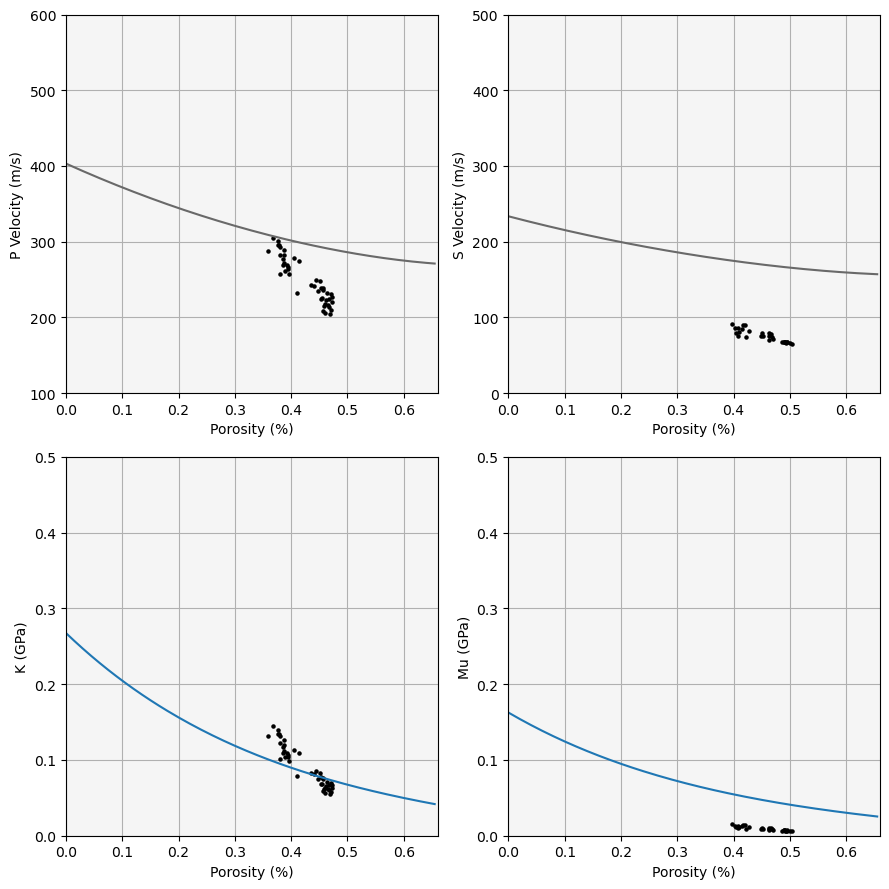

In [29]:
"""
Load the Vp / porosity data from prelim picks, plot with
model fit based on effective minerals

Investigate impact of mineral moduli variations in literature
on model fits, investigate various models
"""

## Model Parameters
pressure = pressures[0]  #GPa for calculations
max_poisson = max_poisson_list[0]

## Calculate RP models
por_range = np.arange(0,critical_porosity, 0.005)

keffs = []
ueffs = []
vp_effs = []
vs_effs = []
vp_hm = []
vs_hm = []


for por in por_range:
    # C = rp.lower_murphy_bounded(por)
    C = rp.upper_murphy(por)
    dens = eff_min_density*(1-por)
    
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, por, C,
                                     pressure, c_ratio = 0.3, slip_percent = 0.99)
    k_hm, u_hm = rp.hertz_mindlin(effective_mineral_k, effective_mineral_u, por, C,
                                     pressure, f=.1)
    
    keffs.append(keff)
    ueffs.append(ueff)
    vp_hm.append(rp.p_vel_mod(k_hm, u_hm, dens)*1000)
    vs_hm.append(rp.s_vel_mod(u_hm, dens)*1000)
    vp_effs.append(rp.p_vel_mod(keff, ueff, dens)*1000)
    vs_effs.append(rp.s_vel_mod(ueff, dens)*1000)

## CALCULATE MODULI
shear_moduli = []
for vs, dens in zip(data_s[:,0], data_s[:,1]):
    shear_moduli.append(rp.shear_mod(vs, dens)/1000000)
avg_vpvs = 2.79
bulk_moduli = []
for vp, dens in zip(data_p[:,0], data_p[:,1]):
    vs = vp/avg_vpvs
    bulk_moduli.append(rp.bulk_mod(vp, vs, dens)/1000000)    
    

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9))
ax[0,0].scatter(data_p[:,2], data_p[:,0], s=5, color="black")
ax[0,0].plot(por_range, vp_effs, label="Working Model", color="dimgray")
# ax[0,0].plot(por_range, vp_hm, color="red")
# ax[0,0].legend()
ax[0,0].set(xlim=(0., round(critical_porosity,2)),
         ylim=(100,600),
         xlabel="Porosity (%)",
         ylabel="P Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,0].grid("both")

ax[0,1].scatter(data_s[:,2], data_s[:,0], s=5, color="black")
ax[0,1].plot(por_range, vs_effs, label="Working Model", color="dimgray")
# ax[0,1].plot(por_range, vs_hm, color="red")
ax[0,1].set(xlim=(0., round(critical_porosity,2)),
         ylim=(0,500),
         xlabel="Porosity (%)",
         ylabel="S Velocity (m/s)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[0,1].grid("both")

ax[1,0].plot(por_range,keffs)
ax[1,0].scatter(data_p[:,2], bulk_moduli, s=5, color="black")
ax[1,0].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.5),
         xlabel="Porosity (%)",
         ylabel="K (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,0].grid("both")

ax[1,1].plot(por_range,ueffs)
ax[1,1].scatter(data_s[:,2], shear_moduli, s=5, color="black")
ax[1,1].set(xlim=(0., round(critical_porosity,2)),
          ylim=(0,0.5),
         xlabel="Porosity (%)",
         ylabel="Mu (GPa)",
         axisbelow=True,
         facecolor="whitesmoke")
ax[1,1].grid("both")

plt.tight_layout()
plt.show()

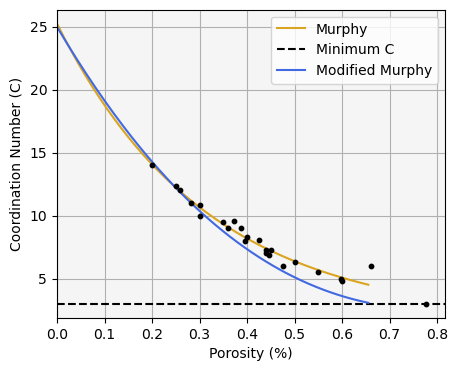

In [6]:
"""
Coordination Number

Ahmed (2018) shows how Micro-CT computed coordination numbers
are lower than the Murphy equation, however this was over more 
'standard' porosity range (i.e. <45%) Plot the upper and lower
Murphy equations over the porosity range used in this study
for investigation.

At ~40% porosity, the lower Murphy equation roughly lines up 
with coordination numbers observed by Ahmed. However, at higher 
porosity C drops below minimum C proposed by German. 

One solution: use the lower Murphy equation but set a with minimum 
C=3. This can result in sharp "kinks" in velocity/moduli with porosity.

Another solution: use Upper Murphy bound and use model fit
parameters to compensate for a likely high value for C

Plotted coordination number data from RPHandbook, pg. 233,
various sources
"""
## Perform least squares fit to coordination number data, use this to define
## the exponential fit for upper murphy
por_cn_pts = [(0.447, 6.87), (0.44, 7.25), (0.426, 8.05), (0.372, 9.57), (0.359, 9.05),
             (0.7766, 3), (0.6599, 6), (0.5969, 5), (0.4764, 6), (0.4388, 7), (0.3955, 8),
             (0.3866, 9), (0.3019, 10), (0.2817, 11), (0.2595, 12), (0.2, 14.007), 
             (0.25, 12.336), (0.3, 10.843), (0.35, 9.508), (0.4, 8.315), (0.45, 7.252),
             (0.5, 6.311), (0.55, 5.488), (0.6, 4.783)]
por_data = [i[0] for i in por_cn_pts]
cn_data = [i[1] for i in por_cn_pts]

def fit_func_cn(porosity, a, b, c):
    n = a*np.exp(b*porosity) - c
    return n

initial_guess = [24, -2.547, 0.3731]
opt_cn_parms, _ = optimize.curve_fit(fit_func_cn, por_data, cn_data, p0=initial_guess)


## Calculate coordination numbers
por_range = np.arange(0,critical_porosity, 0.005)
upper_m = []
lower_m = []
lower_m_bounded = []
mod_murphy = []
for por in por_range:
    upper_m.append(rp.upper_murphy(por))
    lower_m.append(rp.lower_murphy(por))
    lower_m_bounded.append(rp.lower_murphy_bounded(por))
    mod_murphy.append(rp.modified_murphy(por))

plt.figure(figsize=(5,4))
plt.scatter(por_data, cn_data, color="black", s=10, zorder=10)
plt.plot(por_range, upper_m, label="Murphy", c="goldenrod")
# plt.plot(por_range, lower_m, label="Lower Murphy", c="royalblue")
plt.axhline(3, linestyle="--", c='black', label="Minimum C")
# plt.plot(por_range, lower_m_bounded, ls=":", lw=4, label="Bounded Lower Murphy", c="brown")
plt.plot(por_range, mod_murphy, label="Modified Murphy", c="royalblue")
plt.gca().set(xlabel="Porosity (%)",
             ylabel="Coordination Number (C)",
             facecolor="whitesmoke",
             axisbelow=True,
             xlim=(0, None))
plt.grid("both")
plt.legend()
plt.show()

C:\Users\amos\AppData\Local\Temp\ipykernel_14344\4025601590.py:13: RuntimeWarning: divide by zero encountered in log
  preds.append(disp_fit(np.log(_)))


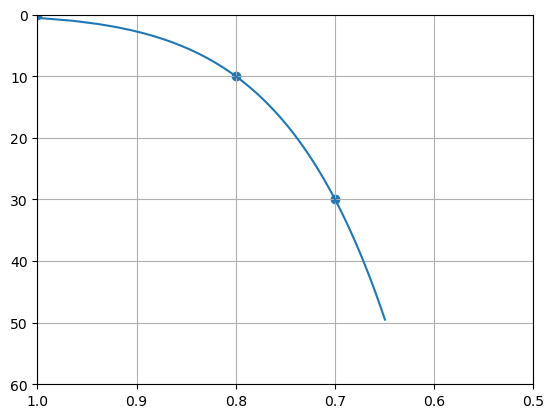

In [66]:

## Create arbitrary dispersion curve
disp_curve = [(0.0001,1), (10, 0.8), (30, 0.7)]
depth_fits = []
disp_fits = []
for disp in disp_curve:
    depth_fits.append(disp[0])
    disp_fits.append(disp[1])
disp_fit = np.poly1d(np.polyfit(np.log(depth_fits), disp_fits, deg=2))

tmp_range = np.arange(0, 50, 0.5)
preds=[]
for _ in tmp_range:
    preds.append(disp_fit(np.log(_)))

plt.scatter(disp_fits, depth_fits)
plt.plot(preds, tmp_range)
plt.grid("both")
plt.xlim(1,0.5)
plt.ylim(60, 0)
plt.show()

C:\Users\amos\AppData\Local\Temp\ipykernel_22152\3784717311.py:39: RuntimeWarning: invalid value encountered in double_scalars
  offset = 2*((ray_param*tmp_vp)/((1-(ray_param**2)*(tmp_vp**2))**(1/2)))
C:\Users\amos\AppData\Local\Temp\ipykernel_22152\3784717311.py:40: RuntimeWarning: invalid value encountered in double_scalars
  time = 2 * (1/(tmp_vp*((1-(ray_param**2)*(tmp_vp**2))**(1/2))**(1/2)))


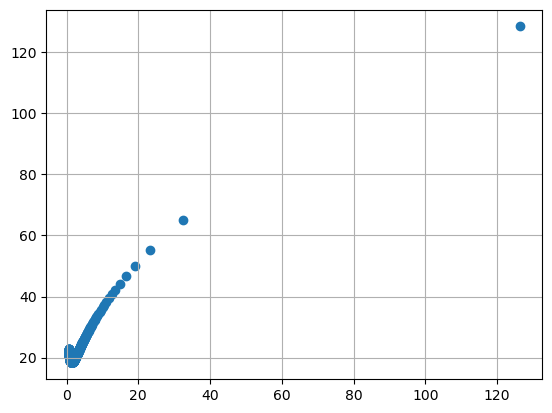

In [16]:
"""
Turning ray approximation
"""

#~~~  Repeating values from above, limiting depth to 10m
## Acceleration due to gravity, in m/s
grav_accel = 1.625
## Specific gravity of regolith
specific_gravity = eff_min_density
## Depth range, in m
max_depth = 10
depth_step = 0.01
depths = np.arange(0,max_depth,depth_step)
## Density equation from Lunar Sourcebook, in g/cm3, page 494
densities = 1.92 * ((depths*100 + 12.2)/(depths*100 + 18))
## Porosity equation from Lunar Sourcebook
porosities = 1 - (densities / specific_gravity)
## Pressure, in MPa
integrated_density = integrate.cumulative_trapezoid(densities)
ss_pressures = np.cumsum((grav_accel * integrated_density * depth_step) / 1e6)
ss_pressures = np.hstack((0, ss_pressures))

OFFSETS = []
TIMES = []
ray_param = 1/350  #(estimating 1/V[Hmax]) from plot above
for por, pressure, dens, depth in zip(porosities, ss_pressures, densities, depths):
    if depth<2:
        continue
    ## Change pressure to GPa
    pressure = pressure/1000
    C = rp.upper_murphy(por)
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                         pressure, c_ratio = contact_ratio, slip_percent = slip_percent)
    keff_uncem, ueff_uncem = rp.amos_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u, 
                                            max_poisson=pr_fit(pressure**(1/10)), fit_por=fitting_por)
    tmp_vp = rp.p_vel_mod(keff_uncem, ueff_uncem, dens)*1000

    offset = 2*((ray_param*tmp_vp)/((1-(ray_param**2)*(tmp_vp**2))**(1/2)))
    time = 2 * (1/(tmp_vp*((1-(ray_param**2)*(tmp_vp**2))**(1/2))**(1/2)))

    OFFSETS.append(offset/2)
    TIMES.append(time*2000)

plt.scatter(OFFSETS, TIMES)
plt.grid("both")
plt.show()

In [43]:
"""
Perform non-linear least squares curve fitting of Amos 
model to Vp to find optimal parameters for Bachrach model
at each pressure step
"""

## Unsure how to control pressure variable for fit function,
## just have to make new functions for each pressure
def fit_func_p0(por, contact_ratio):
    slip = 0.5
    pressure = pressures[0]  #GPa for calculations
    max_poisson = max_poisson_list[0]
    C = 3
    dens = eff_min_density*(1-por)
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     pressure, c_ratio = contact_ratio, slip_percent = slip)
    keff_uncem, ueff_uncem = rp.amos_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u, 
                                            max_poisson=max_poisson, fit_por=fitting_por)
    vp = rp.p_vel_mod(keff_uncem, ueff_uncem, dens)*1000
    return vp
def fit_func_p1(por, contact_ratio):
    slip = 0.5
    pressure = pressures[1]  #GPa for calculations
    max_poisson = max_poisson_list[1]
    C = 3
    dens = eff_min_density*(1-por)
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     pressure, c_ratio = contact_ratio, slip_percent = slip)
    keff_uncem, ueff_uncem = rp.amos_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u, 
                                            max_poisson=max_poisson, fit_por=fitting_por)
    vp = rp.p_vel_mod(keff_uncem, ueff_uncem, dens)*1000
    return vp
def fit_func_p2(por, contact_ratio):
    slip = 0.5
    pressure = pressures[2]  #GPa for calculations
    max_poisson = max_poisson_list[2]
    C = 3
    dens = eff_min_density*(1-por)
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     pressure, c_ratio = contact_ratio, slip_percent = slip)
    keff_uncem, ueff_uncem = rp.amos_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u, 
                                            max_poisson=max_poisson, fit_por=fitting_por)
    vp = rp.p_vel_mod(keff_uncem, ueff_uncem, dens)*1000
    return vp
def fit_func_p3(por, contact_ratio):
    slip = 0.5
    pressure = pressures[3]  #GPa for calculations
    max_poisson = max_poisson_list[3]
    C = 3
    dens = eff_min_density*(1-por)
    keff, ueff = rp.bachrach_angular(effective_mineral_k, effective_mineral_u, critical_porosity, C,
                                     pressure, c_ratio = contact_ratio, slip_percent = slip)
    keff_uncem, ueff_uncem = rp.amos_model(por, critical_porosity, keff, ueff, 
                                            effective_mineral_k, effective_mineral_u, 
                                            max_poisson=max_poisson, fit_por=fitting_por)
    vp = rp.p_vel_mod(keff_uncem, ueff_uncem, dens)*1000
    return vp
    

## Lease squares parameters
## Note: low pressure fit suggests a low slip percent but higher
## pressure data returns a high slip percent, which is illogical.
## Set bounds to control slip percent to remain at a low value
# initial_guess = [0.07, 0.1]
# bounds = ([0., 0.1], [0.3, 0.6])
initial_guess = 0.07
bounds=(0., 0.9)

## Find best parameters at each pressure
opt_parms_p0, _ = optimize.curve_fit(fit_func_p0, data_p[:,2], data_p[:,0],
                                 p0=initial_guess, bounds=bounds)
opt_cr_p0 = round(opt_parms_p0[0], 3)

opt_parms_p1, _ = optimize.curve_fit(fit_func_p1, pres_step_1_p[:,2], pres_step_1_p[:,0],
                                 p0=initial_guess, bounds=bounds)
opt_cr_p1 = round(opt_parms_p1[0], 3)

opt_parms_p2, _ = optimize.curve_fit(fit_func_p2, pres_step_2_p[:,2], pres_step_2_p[:,0],
                                 p0=initial_guess, bounds=bounds)
opt_cr_p2 = round(opt_parms_p2[0], 3)

opt_parms_p3, _ = optimize.curve_fit(fit_func_p3, pres_step_3_p[:,2], pres_step_3_p[:,0],
                                 p0=initial_guess, bounds=bounds)
opt_cr_p3 = round(opt_parms_p3[0], 3)

pressure_strings = [str(round(i*1000,3))+" MPa" for i in pressures]
pressure_strings.append("Average")
fit_dict = {
    "Pressure" : pressure_strings,
    "Optimal Contact Ratio": [opt_cr_p0, opt_cr_p1, opt_cr_p2, opt_cr_p3,
                             np.average([opt_cr_p0, opt_cr_p1, opt_cr_p2, opt_cr_p3])]
}

# opt_parms_p0, _ = optimize.curve_fit(fit_func_p0, pres_step_0_p[:,2], pres_step_0_p[:,0],
#                                  p0=initial_guess, bounds=bounds)
# opt_cr_p0, opt_slip_p0 = round(opt_parms_p0[0], 3), round(opt_parms_p0[1], 3)

# opt_parms_p1, _ = optimize.curve_fit(fit_func_p1, pres_step_1_p[:,2], pres_step_1_p[:,0],
#                                  p0=initial_guess, bounds=bounds)
# opt_cr_p1, opt_slip_p1 = round(opt_parms_p1[0], 3), round(opt_parms_p1[1], 3)

# opt_parms_p2, _ = optimize.curve_fit(fit_func_p2, pres_step_2_p[:,2], pres_step_2_p[:,0],
#                                  p0=initial_guess, bounds=bounds)
# opt_cr_p2, opt_slip_p2 = round(opt_parms_p2[0], 3), round(opt_parms_p2[1], 3)

# opt_parms_p3, _ = optimize.curve_fit(fit_func_p3, pres_step_3_p[:,2], pres_step_3_p[:,0],
#                                  p0=initial_guess, bounds=bounds)
# opt_cr_p3, opt_slip_p3 = round(opt_parms_p3[0], 3), round(opt_parms_p3[1], 3)

# fit_dict = {
#     "Pressure" : [str(round(i*1000,3))+" MPa" for i in pressures],
#     "Optimal Contact Ratio": [opt_cr_p0, opt_cr_p1, opt_cr_p2, opt_cr_p3],
#     "Optimal Slip Percent": [opt_slip_p0, opt_slip_p1, opt_slip_p2, opt_slip_p3]
# }


display_df = pd.DataFrame(fit_dict)
HTML(display_df.to_html(index=False))

Pressure,Optimal Contact Ratio
0.005 MPa,0.62800
0.03 MPa,0.90000
0.055 MPa,0.88800
0.08 MPa,0.89500
Average,0.82775
